In [259]:
import pandas as pd
import itertools
import random
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, text
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score

In [260]:
%ls

 Volume in drive C is OS
 Volume Serial Number is 32CC-3519

 Directory of c:\Users\npwol\OneDrive\Desktop\leaflet-challenge\Final-Project-Spotify

10/17/2024  06:04 PM    <DIR>          .
10/17/2024  05:57 PM    <DIR>          ..
10/17/2024  06:04 PM         2,427,231 Leo_Spotify1.ipynb
10/17/2024  06:26 PM         2,910,866 Noah_Spotify.ipynb
10/17/2024  06:04 PM           550,510 Paola_Spotify_Optimization.ipynb
10/17/2024  06:04 PM            33,170 Paola_Spotify_Optimization_PCA.ipynb
10/17/2024  06:04 PM    <DIR>          Resources
10/17/2024  06:04 PM           208,232 Sadaf_Spotify_KMeans.ipynb
10/17/2024  06:04 PM           297,750 spotify_cleaned.ipynb
10/17/2024  06:04 PM                 0 your_database.db
               7 File(s)      6,427,759 bytes
               3 Dir(s)  801,245,523,968 bytes free


In [261]:
#Create Database Connection
engine = create_engine("sqlite:///Resources/spotify_2023.sqlite", echo=False)

In [262]:
%ls

 Volume in drive C is OS
 Volume Serial Number is 32CC-3519

 Directory of c:\Users\npwol\OneDrive\Desktop\leaflet-challenge\Final-Project-Spotify

10/17/2024  06:04 PM    <DIR>          .
10/17/2024  05:57 PM    <DIR>          ..
10/17/2024  06:04 PM         2,427,231 Leo_Spotify1.ipynb
10/17/2024  06:26 PM         2,910,866 Noah_Spotify.ipynb
10/17/2024  06:04 PM           550,510 Paola_Spotify_Optimization.ipynb
10/17/2024  06:04 PM            33,170 Paola_Spotify_Optimization_PCA.ipynb
10/17/2024  06:04 PM    <DIR>          Resources
10/17/2024  06:04 PM           208,232 Sadaf_Spotify_KMeans.ipynb
10/17/2024  06:04 PM           297,750 spotify_cleaned.ipynb
10/17/2024  06:04 PM                 0 your_database.db
               7 File(s)      6,427,759 bytes
               3 Dir(s)  801,245,523,968 bytes free


In [263]:
#Refelect Database into ORM Classes
Base = automap_base()
Base.prepare(autoload_with=engine, reflect=True)
Base.classes.keys()

C:\Users\npwol\AppData\Local\Temp\ipykernel_78468\2310885986.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(autoload_with=engine, reflect=True)


['cleaned_spotify_2023']

In [264]:
cleaned_spotify_2023 = Base.classes.cleaned_spotify_2023

In [265]:
session = Session(engine)

In [266]:
#get a list of column names and types
inspector = inspect(engine)
columns = inspector.get_columns('cleaned_spotify_2023')

for col in columns:
    print(col['name'], col['type'])

ID INTEGER
track_name TEXT
artist(s)_name TEXT
contributing_artist_count INTEGER
released_year INTEGER
released_month INTEGER
in_spotify_playlists INTEGER
spotify_chart_rank INTEGER
streams INTEGER
in_apple_playlists INTEGER
apple_chart_rank INTEGER
in_deezer_playlists INTEGER
deezer_chart_rank INTEGER
shazam_chart_rank INTEGER
bpm INTEGER
key TEXT
mode TEXT
danceability_% INTEGER
valence_% INTEGER
energy_% INTEGER
acousticness_% INTEGER
instrumentalness_% INTEGER
liveness_% INTEGER
speechiness_% INTEGER


In [267]:
# Assuming df is your DataFrame after loading the data from the SQLAlchemy engine
clean_spotify_df = pd.read_sql_table('cleaned_spotify_2023', engine)

col_list = []
for col in clean_spotify_df.columns:
    col_list.append(str(col))
clean_spotify_df.columns=col_list

# Rename 'artist(s)_name' to 'artists_name'
cleaned_spotify_df = clean_spotify_df.rename(columns={'artist(s)_name': 'artists_name',
                        'danceability_%': 'danceability',
                        'valence_%': 'valence',
                        'energy_%': 'energy', 
                        'acousticness_%': 'acousticness', 
                        'instrumentalness_%': 'instrumentalness',  
                        'liveness_%': 'liveness',
                        'speechiness_%': 'speechiness'
                        })

# Verify the change
print(cleaned_spotify_df.columns)

Index(['ID', 'track_name', 'artists_name', 'contributing_artist_count',
       'released_year', 'released_month', 'in_spotify_playlists',
       'spotify_chart_rank', 'streams', 'in_apple_playlists',
       'apple_chart_rank', 'in_deezer_playlists', 'deezer_chart_rank',
       'shazam_chart_rank', 'bpm', 'key', 'mode', 'danceability', 'valence',
       'energy', 'acousticness', 'instrumentalness', 'liveness',
       'speechiness'],
      dtype='object')


In [268]:
# Group by artist name and calculate the total streams for each artist
artist_streams = cleaned_spotify_df.groupby('artists_name')['streams'].sum().reset_index()

# Rank artists based on total streams (higher streams get a lower rank value)
artist_streams['artist_rank'] = artist_streams['streams'].rank(method='dense', ascending=False)

# Merge the rank back into the original DataFrame
cleaned_spotify_df = cleaned_spotify_df.merge(artist_streams[['artists_name', 'artist_rank']], on='artists_name', how='left')

# Verify the rank column
print(cleaned_spotify_df[['artists_name', 'streams', 'artist_rank']].head())

      artists_name    streams  artist_rank
0  latto jung kook  141381703        433.0
1      myke towers  133716286        450.0
2   olivia rodrigo  140003974         12.0
3     taylor swift  800840817          1.0
4        bad bunny  303236322          3.0


R² Score: 0.8188750669019409


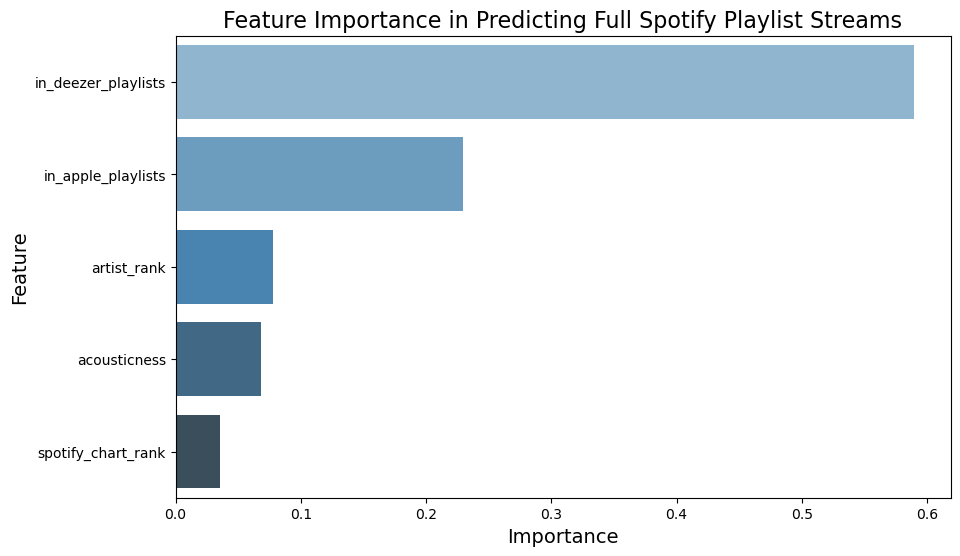

VIF Data:
               Feature        VIF
0          artist_rank   3.084966
1   in_apple_playlists   2.248038
2        released_year  90.086633
3  in_deezer_playlists   1.617785
4   spotify_chart_rank   1.482896
5              valence   8.144812
6               energy  29.681134
7         danceability  30.537725
8                  bpm  20.776929
9         acousticness   3.347037
Features excluded due to high VIF (> 5):
2    released_year
5          valence
6           energy
7     danceability
8              bpm
Name: Feature, dtype: object


In [269]:
# Step 1: Select the features for VIF calculation and model training
# Use 'artist_rank' instead of 'artist_streams'
X = cleaned_spotify_df[['artist_rank', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'acousticness']]

# Step 2: Set the full `streams` target variable
y = cleaned_spotify_df['in_spotify_playlists']

# Step 3: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X.drop(columns=high_vif_features)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 5: Scale the numeric columns
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train the RandomForestRegressor to predict the full `streams`
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 7: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 8: Calculate regression metrics
r2 = r2_score(y_test, y_pred)

# Print the R² for the `streams` prediction
print(f"R² Score: {r2}")

# Step 9: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 10: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title(f'Feature Importance in Predicting Full Spotify Playlist Streams', fontsize=16)
plt.show()

# Display VIF results
print("VIF Data:")
print(vif_data)

# Print excluded features due to high VIF
print("Features excluded due to high VIF (> 5):")
print(high_vif_features)


In [270]:
cleaned_spotify_df.head()

,ID,track_name,artists_name,contributing_artist_count,released_year,released_month,in_spotify_playlists,spotify_chart_rank,streams,in_apple_playlists,...,key,mode,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness,artist_rank
0,1,seven feat latto explicit ver,latto jung kook,2,2023,7,553,147,141381703,43,...,B,Major,80,89,83,31,0,8,4,433.0
1,2,lala,myke towers,1,2023,3,1474,48,133716286,48,...,C#,Major,71,61,74,7,0,10,4,450.0
2,3,vampire,olivia rodrigo,1,2023,6,1397,113,140003974,94,...,F,Major,51,32,53,17,0,31,6,12.0
3,4,cruel summer,taylor swift,1,2019,8,7858,100,800840817,116,...,A,Major,55,58,72,11,0,11,15,1.0
4,5,where she goes,bad bunny,1,2023,5,3133,50,303236322,84,...,A,Minor,65,23,80,14,63,11,6,3.0


In [271]:
cleaned_spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817 entries, 0 to 816
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         817 non-null    int64  
 1   track_name                 815 non-null    object 
 2   artists_name               817 non-null    object 
 3   contributing_artist_count  817 non-null    int64  
 4   released_year              817 non-null    int64  
 5   released_month             817 non-null    int64  
 6   in_spotify_playlists       817 non-null    int64  
 7   spotify_chart_rank         817 non-null    int64  
 8   streams                    817 non-null    int64  
 9   in_apple_playlists         817 non-null    int64  
 10  apple_chart_rank           817 non-null    int64  
 11  in_deezer_playlists        817 non-null    int64  
 12  deezer_chart_rank          817 non-null    int64  
 13  shazam_chart_rank          817 non-null    int64  

In [272]:
# X.columns = X.columns.astype(str)  

# Step 1: Assume 'cleaned_spotify_db' is your DataFrame and exclude 'key' and 'mode'
X = cleaned_spotify_df.drop(columns=['ID', 'streams', 'track_name', 'artists_name', 'key', 'mode'])


# Target variable
y = cleaned_spotify_df['streams']
# y.columns = y.columns.astype(str)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Step 3: Scale the numeric columns
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

# Step 4: Convert scaled data back to DataFrames to retain feature names
# X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
# X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Step 5: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 7: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

Mean Squared Error: 2.250082569413988e+16
Root Mean Squared Error: 150002752.2885493
Mean Absolute Error: 93836032.71693902
R² Score: 0.8892521293971556


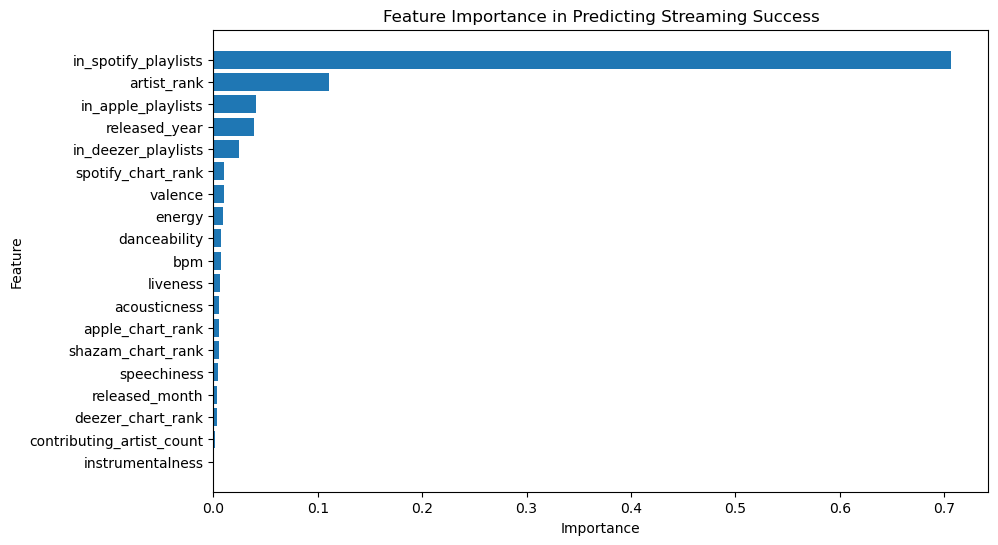

In [273]:
# Extract feature importances
importances = rf.feature_importances_

# Create a DataFrame to associate features with their importance
feature_names = X_train.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting Streaming Success')
plt.gca().invert_yaxis()  
plt.show()


Mean Squared Error: 1.1587092398201586e+17
Root Mean Squared Error: 340398184.45757884
Mean Absolute Error: 196056710.36029264
R² Score: 0.4296894580568922


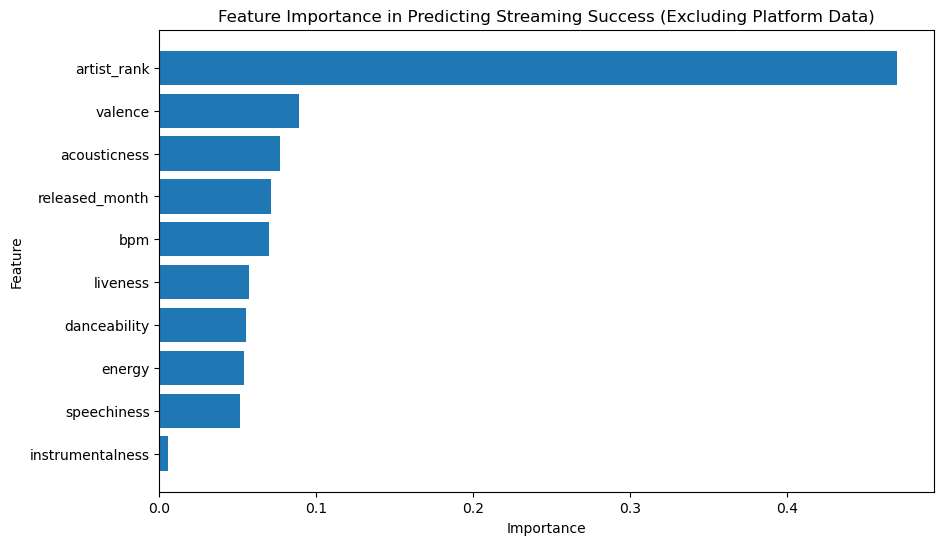

In [274]:
# Assuming 'cleaned_spotify_df' is your DataFrame
X = cleaned_spotify_df.drop(columns=[
    'ID', 'streams', 'track_name', 'artists_name', 
    'in_spotify_playlists', 'spotify_chart_rank', 
    'in_apple_playlists', 'apple_chart_rank', 
    'in_deezer_playlists', 'deezer_chart_rank', 
    'shazam_chart_rank', 'key', 'mode', 'released_year', 'contributing_artist_count'])

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Step 3: Scale the numeric columns
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 5: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 6: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Step 7: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_train.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting Streaming Success (Excluding Platform Data)')
plt.gca().invert_yaxis()  
plt.show()


Mean Squared Error: 2.1843786682123184e+16
Root Mean Squared Error: 147796436.63540465
Mean Absolute Error: 90876787.81346342
R² Score: 0.8924860405643709


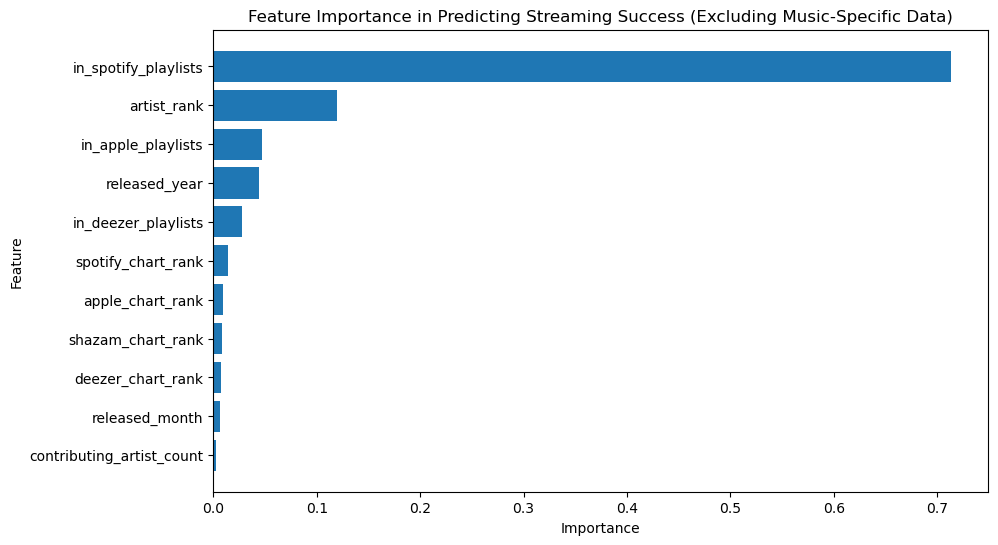

In [275]:
# Assuming 'cleaned_spotify_df' is your DataFrame
X = cleaned_spotify_df.drop(columns=[
    'ID', 'streams', 'track_name', 
    'bpm', 'key', 'mode', 'danceability', 'valence', 'energy', 
    'acousticness', 'instrumentalness', 'liveness', 'speechiness', 'artists_name'])

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Step 3: Scale the numeric columns (no non-numeric columns included now)
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 5: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 6: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Step 7: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_train.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting Streaming Success (Excluding Music-Specific Data)')
plt.gca().invert_yaxis()  
plt.show()


Mean Squared Error: 2.421948073237594e+16
Root Mean Squared Error: 155626092.71062467
Mean Absolute Error: 84766653.34931096
R² Score: 0.8807930004579422


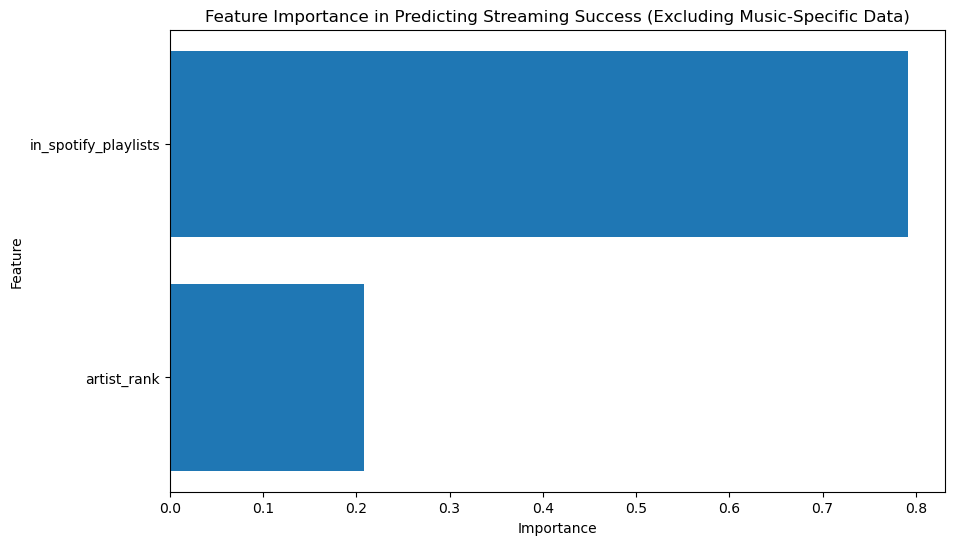

In [276]:
# Assuming 'cleaned_spotify_df' is your DataFrame
X = cleaned_spotify_df.drop(columns=['ID', 'streams', 'track_name', 
    'bpm', 'key', 'mode', 'danceability', 'valence', 'energy', 
    'acousticness', 'instrumentalness', 'liveness', 'speechiness', 'artists_name', 
    'spotify_chart_rank', 'in_apple_playlists', 'apple_chart_rank', 
    'in_deezer_playlists', 'deezer_chart_rank', 'shazam_chart_rank', 
    'released_year', 'released_month', 'contributing_artist_count'])

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Step 3: Scale the numeric columns (no non-numeric columns included now)
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 5: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 6: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Step 7: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_train.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting Streaming Success (Excluding Music-Specific Data)')
plt.gca().invert_yaxis()  
plt.show()


Mean Squared Error: 3.603117396565782e+16
Root Mean Squared Error: 189818792.44600052
Mean Absolute Error: 127787229.38599391
R² Score: 0.8226564728663932


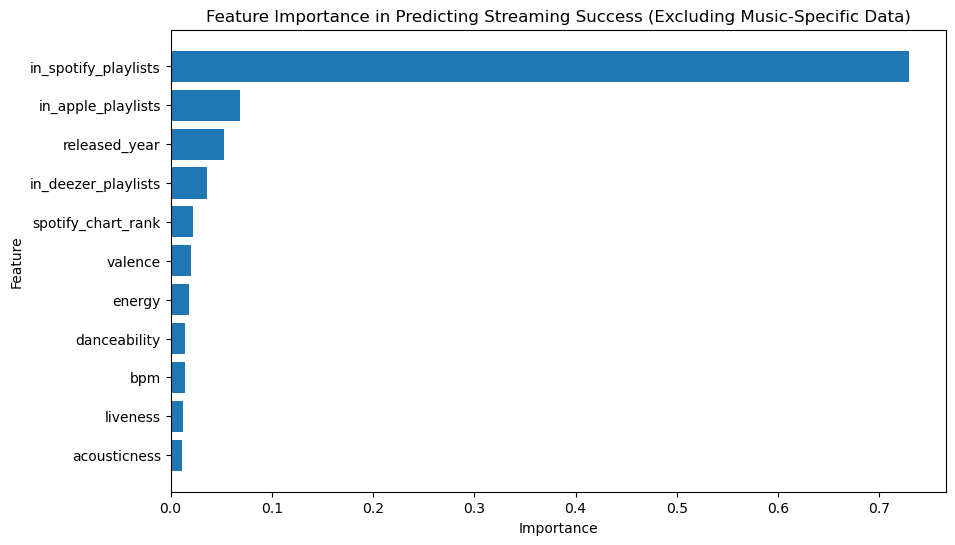

In [277]:
X = cleaned_spotify_df[['in_spotify_playlists', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Step 3: Scale the numeric columns (no non-numeric columns included now)
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 5: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 6: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Step 7: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_train.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting Streaming Success (Excluding Music-Specific Data)')
plt.gca().invert_yaxis()  
plt.show()


In [278]:
# Sort the DataFrame by 'streams' in descending order to get the most streamed tracks
sorted_df = cleaned_spotify_df.sort_values(by='streams', ascending=False)

# Select the top 5 most streamed tracks and include the audio qualities and features of streaming
top_streamed_tracks = sorted_df[['track_name', 'artists_name', 'streams', 
                                 'in_spotify_playlists', 'in_apple_playlists', 
                                 'released_year', 'in_deezer_playlists', 
                                 'spotify_chart_rank', 'valence', 'energy', 
                                 'danceability', 'bpm', 'liveness', 'acousticness']].head(5)

# Save the result to the 'top_streamed_tracks' variable
top_str = top_streamed_tracks

# Print the top 5 most streamed tracks with additional features
print("Top 5 Most Streamed Tracks with Audio Qualities and Streaming Features:")
print(top_str)


Top 5 Most Streamed Tracks with Audio Qualities and Streaming Features:
                                    track_name                 artists_name  \
151                               shape of you                   ed sheeran   
36   sunflower  spiderman into the spiderverse         post malone swae lee   
137                                  one dance            drake wizkid kyla   
71                     stay with justin bieber  justin bieber the kid laroi   
122                                   believer              imagine dragons   

        streams  in_spotify_playlists  in_apple_playlists  released_year  \
151  3562543890                 32181                  33           2017   
36   2808096550                 24094                 372           2018   
137  2713922350                 43257                 433           2016   
71   2665343922                 17050                 492           2021   
122  2594040133                 18986                 250           2017 

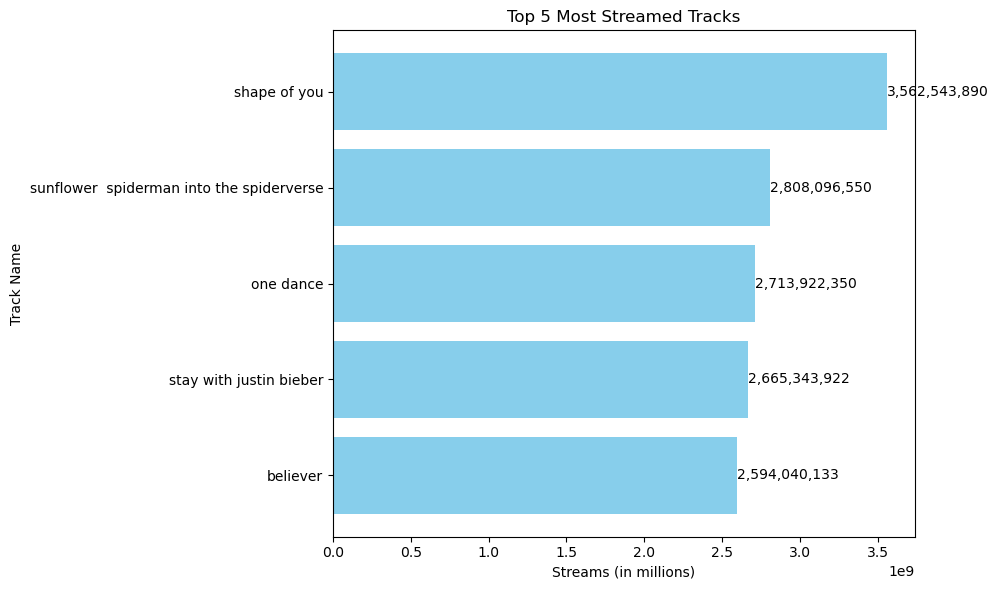

In [279]:
# Sort the DataFrame by 'streams' in descending order
top_streamed_tracks_sorted = top_streamed_tracks.sort_values(by='streams', ascending=True)

# Create a bar graph for stream counts
plt.figure(figsize=(10, 6))

# Horizontal bar graph for 'streams' in descending order
plt.barh(top_streamed_tracks_sorted['track_name'], top_streamed_tracks_sorted['streams'], color='skyblue')

# Add labels and title
plt.xlabel('Streams (in millions)')
plt.ylabel('Track Name')
plt.title('Top 5 Most Streamed Tracks')

# Display stream count on the bars
for index, value in enumerate(top_streamed_tracks_sorted['streams']):
    plt.text(value, index, f'{value:,.0f}', va='center')

# Show the plot
plt.tight_layout()
plt.show()


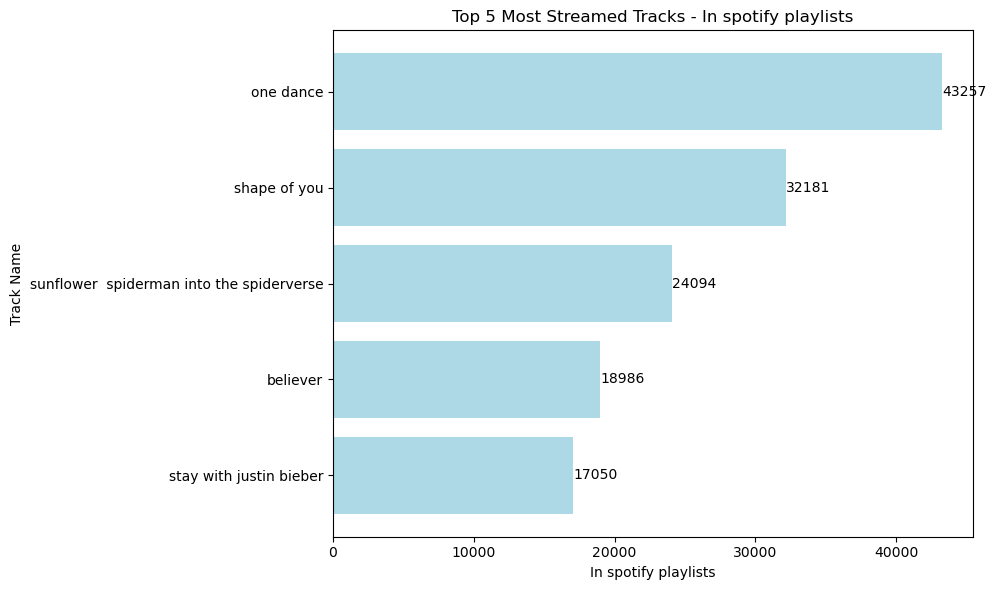

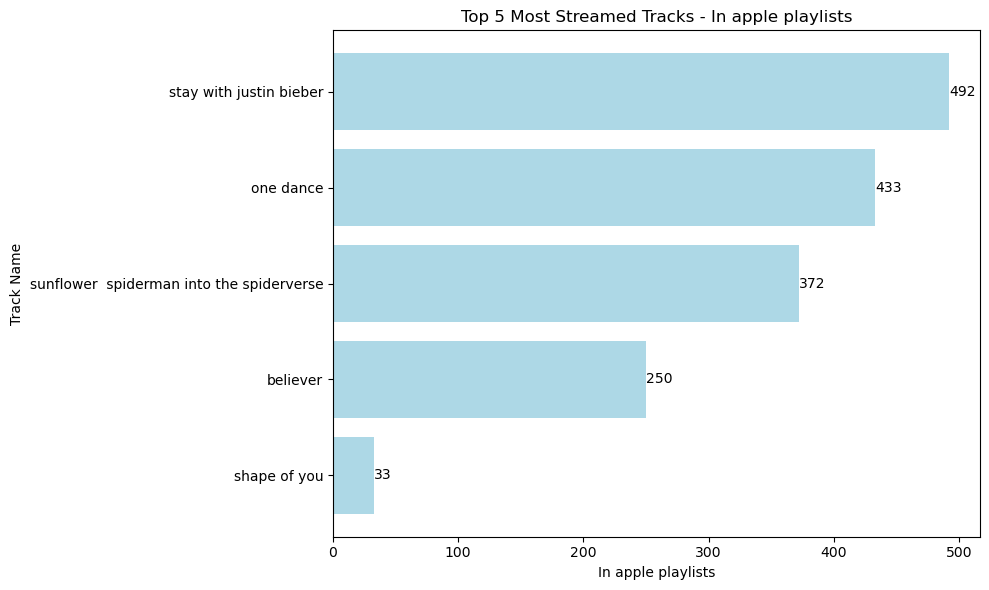

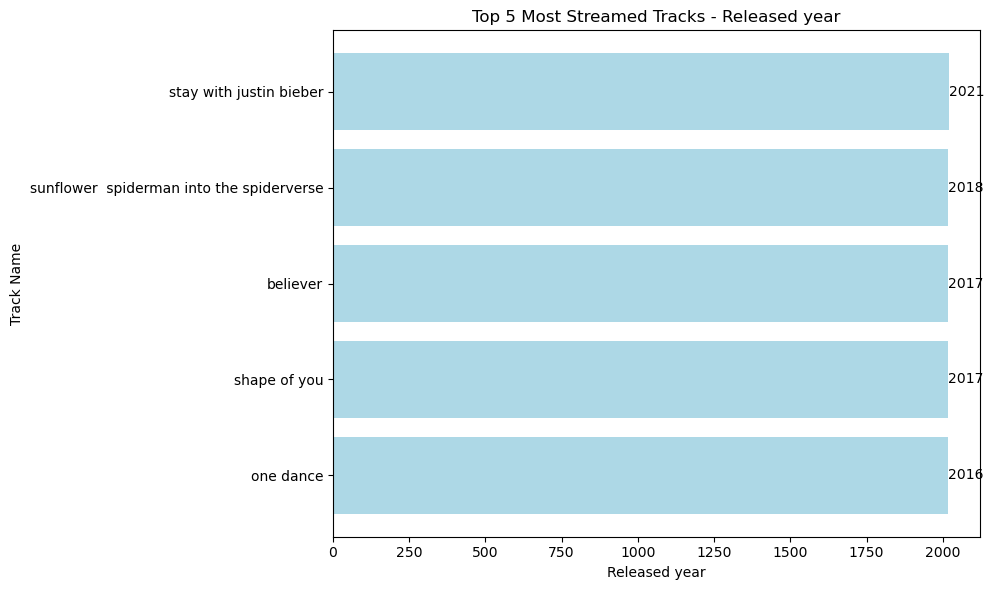

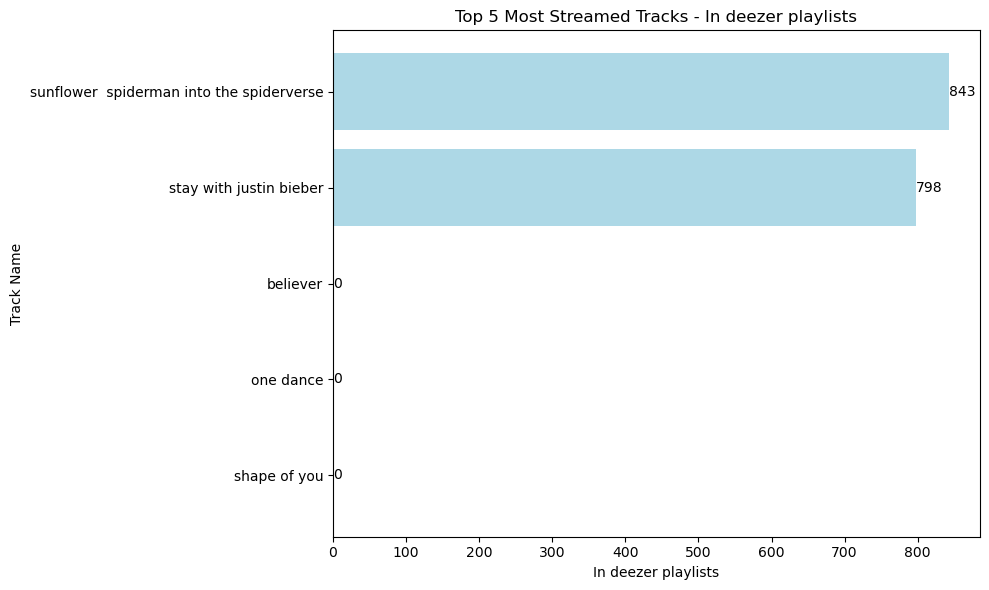

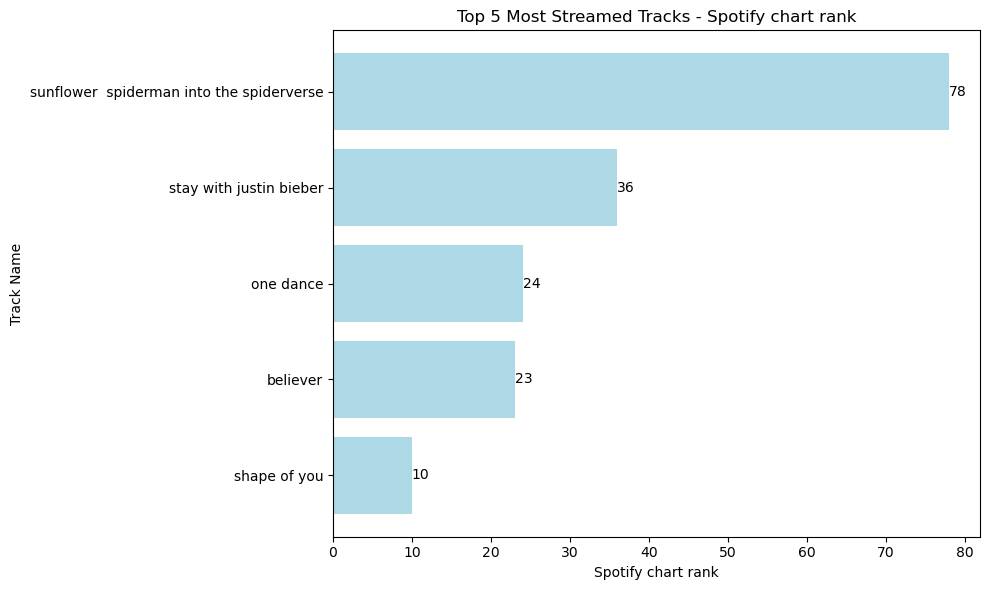

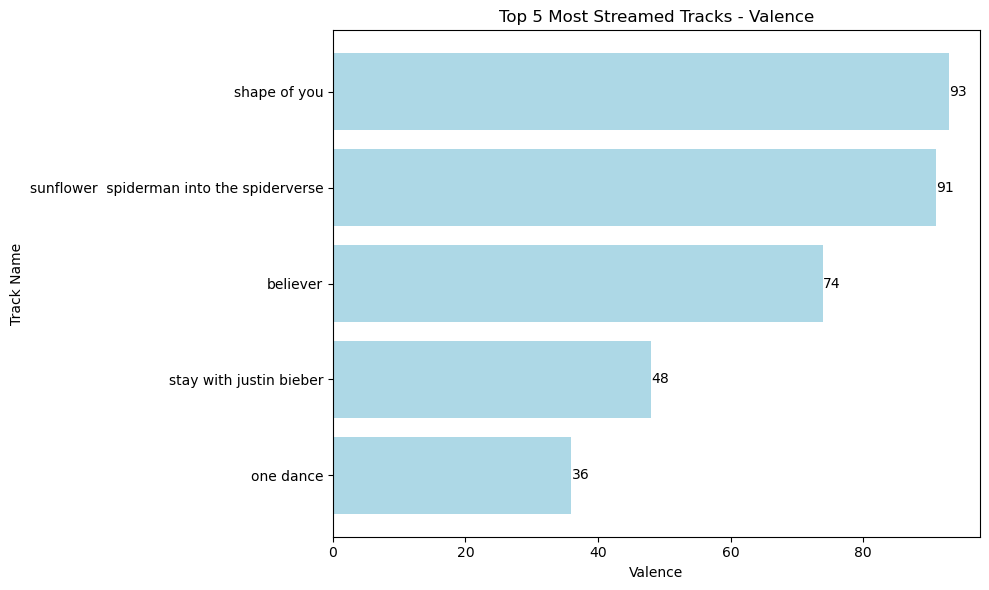

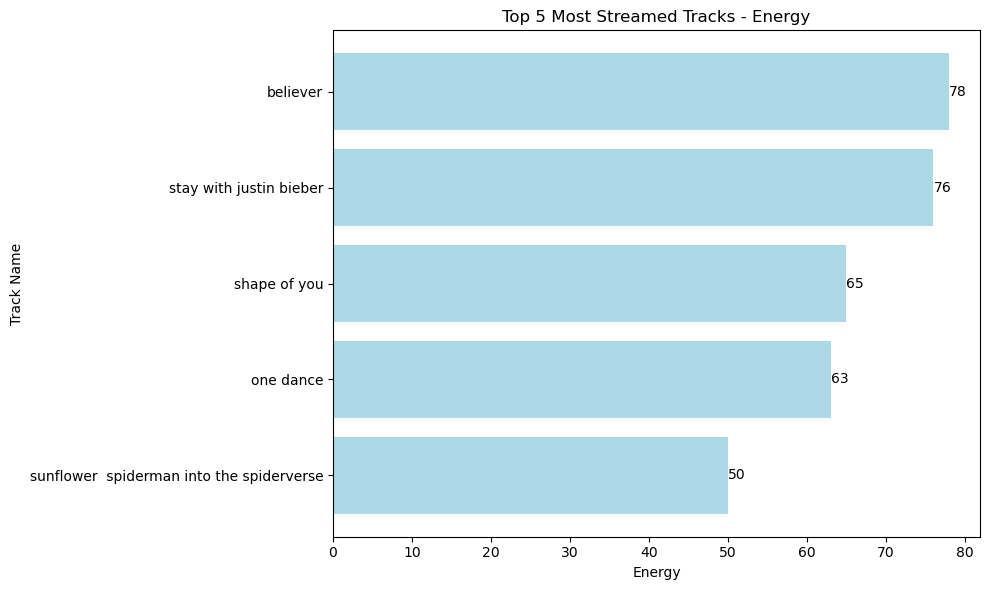

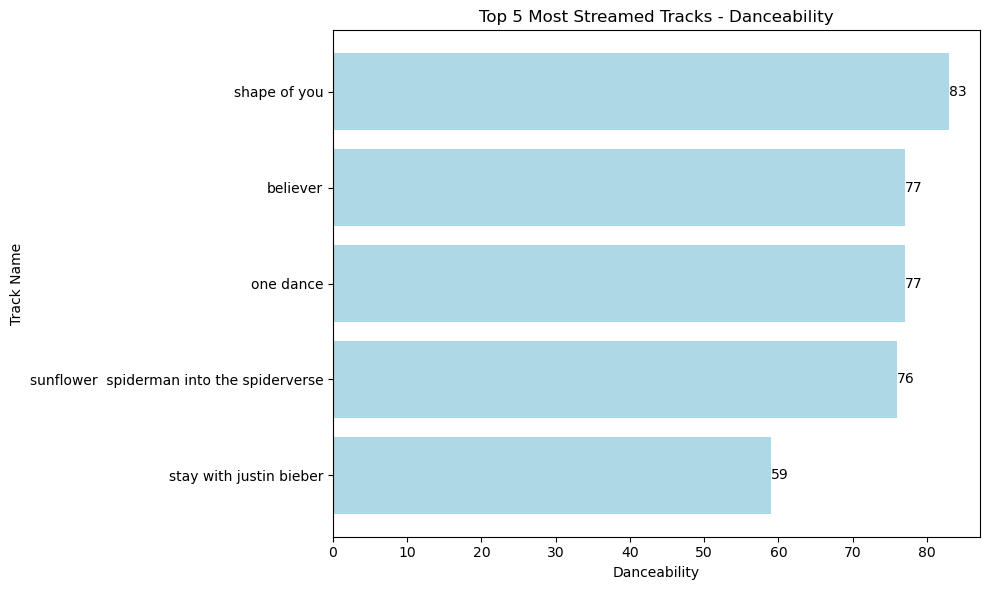

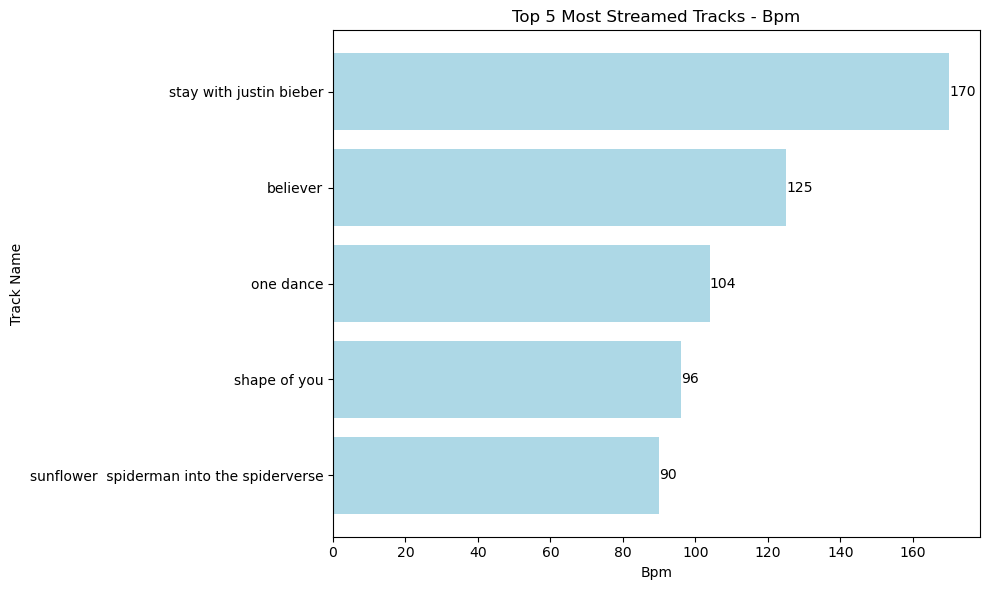

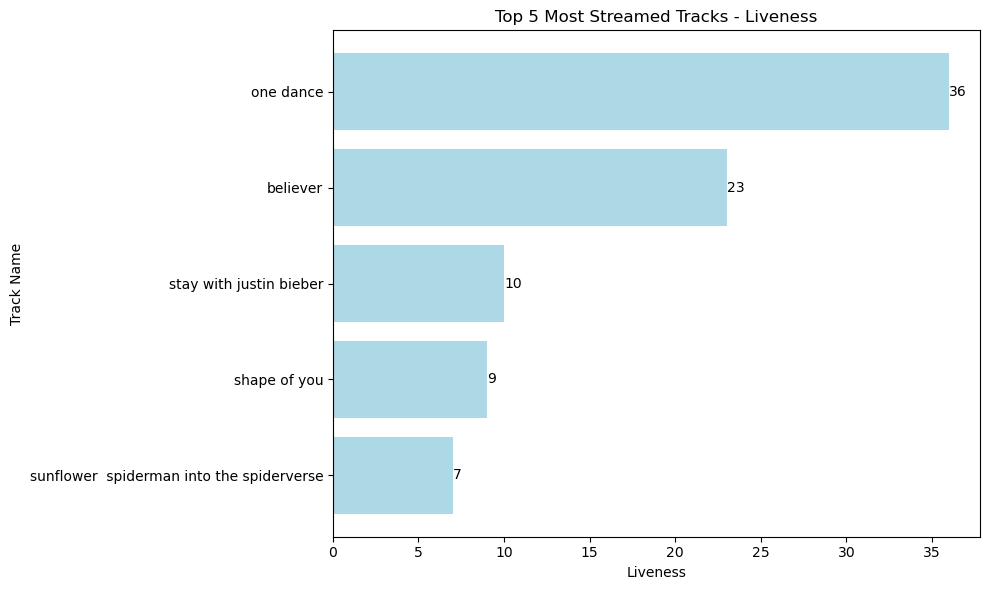

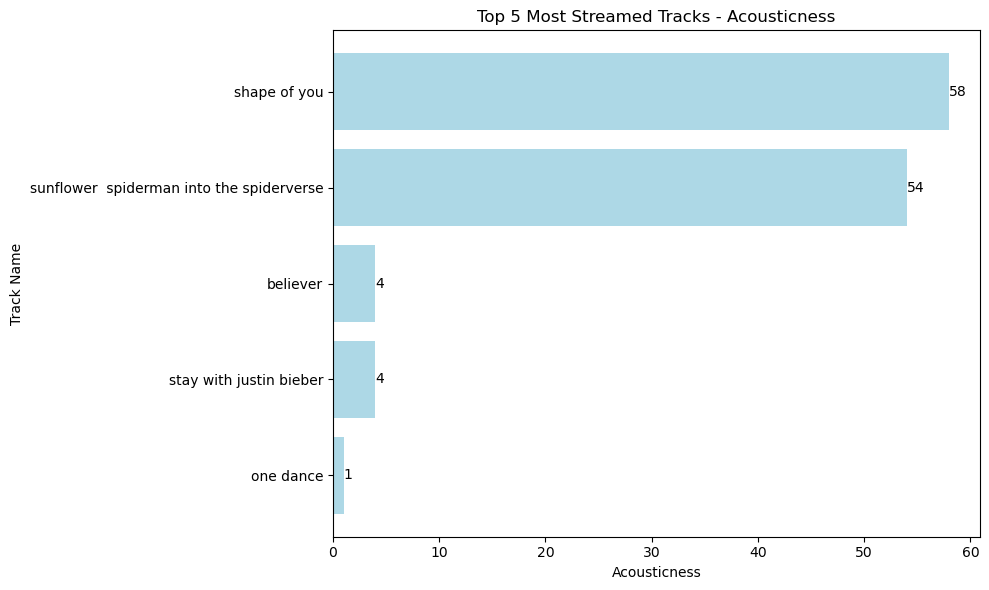

In [280]:
# Sort the DataFrame by 'streams' in descending order to get the top 5 most streamed tracks
sorted_df = cleaned_spotify_df.sort_values(by='streams', ascending=False)

# Select the top 5 most streamed tracks and include the audio qualities and features of streaming
top_streamed_tracks = sorted_df[['track_name', 'artists_name', 'streams', 
                                 'in_spotify_playlists', 'in_apple_playlists', 
                                 'released_year', 'in_deezer_playlists', 
                                 'spotify_chart_rank', 'valence', 'energy', 
                                 'danceability', 'bpm', 'liveness', 'acousticness']].head(5)

# Features to generate bar graphs for
features = ['in_spotify_playlists', 'in_apple_playlists', 'released_year', 
            'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
            'energy', 'danceability', 'bpm', 'liveness', 'acousticness']

# Function to plot a bar graph for each feature dynamically from the DataFrame
def plot_feature_bar_graphs(top_streamed_tracks, features):
    for feature in features:
        # Sort the DataFrame by the current feature in descending order
        sorted_tracks = top_streamed_tracks.sort_values(by=feature, ascending=True)
        
        plt.figure(figsize=(10, 6))
        
        # Create a horizontal bar graph for each feature
        plt.barh(sorted_tracks['track_name'], sorted_tracks[feature], color='lightblue')
        
        # Add labels and title
        plt.xlabel(feature.replace('_', ' ').capitalize())
        plt.ylabel('Track Name')
        plt.title(f'Top 5 Most Streamed Tracks - {feature.replace("_", " ").capitalize()}')
        
        # Annotate bars with the values
        for index, value in enumerate(sorted_tracks[feature]):
            plt.text(value, index, f'{value}', va='center')
        
        # Show the plot
        plt.tight_layout()
        plt.show()

# Call the function to plot the bar graphs for all features
plot_feature_bar_graphs(top_streamed_tracks, features)


In [281]:
sorted_spotify_df = cleaned_spotify_df.sort_values(by=['streams'], ascending=False)
sorted_spotify_df

,ID,track_name,artists_name,contributing_artist_count,released_year,released_month,in_spotify_playlists,spotify_chart_rank,streams,in_apple_playlists,...,key,mode,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness,artist_rank
151,152,shape of you,ed sheeran,1,2017,1,32181,10,3562543890,33,...,C#,Minor,83,93,65,58,0,9,8,2.0
36,37,sunflower spiderman into the spiderverse,post malone swae lee,2,2018,10,24094,78,2808096550,372,...,D,Major,76,91,50,54,0,7,5,18.0
137,138,one dance,drake wizkid kyla,3,2016,4,43257,24,2713922350,433,...,C#,Major,77,36,63,1,0,36,5,20.0
71,72,stay with justin bieber,justin bieber the kid laroi,2,2021,7,17050,36,2665343922,492,...,C#,Major,59,48,76,4,0,10,5,24.0
122,123,believer,imagine dragons,1,2017,1,18986,23,2594040133,250,...,A#,Minor,77,74,78,4,0,23,11,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,58,overdrive,post malone,1,2023,7,410,36,14780425,36,...,C#,Major,56,48,73,0,0,35,4,380.0
124,125,gol bolinha gol quadrado 2,mc pedrinho dj 900,2,2023,6,293,8,11956641,5,...,B,Minor,93,68,65,42,0,12,25,566.0
342,343,jhoome jo pathaan,arijit singh vishal dadlani sukriti kakar vish...,6,2022,12,138,4,1365184,13,...,G,Major,82,62,74,10,0,33,7,567.0
109,110,que vuelvas,carin leon grupo frontera,2,2022,12,763,26,2762,21,...,A#,Major,49,78,64,19,0,11,4,568.0


In [282]:
sorted_spotify_df = sorted_spotify_df.drop([151])
sorted_spotify_df


,ID,track_name,artists_name,contributing_artist_count,released_year,released_month,in_spotify_playlists,spotify_chart_rank,streams,in_apple_playlists,...,key,mode,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness,artist_rank
36,37,sunflower spiderman into the spiderverse,post malone swae lee,2,2018,10,24094,78,2808096550,372,...,D,Major,76,91,50,54,0,7,5,18.0
137,138,one dance,drake wizkid kyla,3,2016,4,43257,24,2713922350,433,...,C#,Major,77,36,63,1,0,36,5,20.0
71,72,stay with justin bieber,justin bieber the kid laroi,2,2021,7,17050,36,2665343922,492,...,C#,Major,59,48,76,4,0,10,5,24.0
122,123,believer,imagine dragons,1,2017,1,18986,23,2594040133,250,...,A#,Minor,77,74,78,4,0,23,11,7.0
611,612,closer,the chainsmokers halsey,2,2016,5,28032,0,2591224264,315,...,G#,Major,75,64,52,41,0,11,3,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,58,overdrive,post malone,1,2023,7,410,36,14780425,36,...,C#,Major,56,48,73,0,0,35,4,380.0
124,125,gol bolinha gol quadrado 2,mc pedrinho dj 900,2,2023,6,293,8,11956641,5,...,B,Minor,93,68,65,42,0,12,25,566.0
342,343,jhoome jo pathaan,arijit singh vishal dadlani sukriti kakar vish...,6,2022,12,138,4,1365184,13,...,G,Major,82,62,74,10,0,33,7,567.0
109,110,que vuelvas,carin leon grupo frontera,2,2022,12,763,26,2762,21,...,A#,Major,49,78,64,19,0,11,4,568.0


In [283]:
# Step 1: Assume 'cleaned_spotify_db' is your DataFrame and exclude 'key' and 'mode'
X = sorted_spotify_df.drop(columns=['ID', 'streams', 'track_name', 'artists_name', 'key', 'mode'])


# Target variable
y = sorted_spotify_df['streams']
# y.columns = y.columns.astype(str)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Step 3: Scale the numeric columns
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

# Step 4: Convert scaled data back to DataFrames to retain feature names
# X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
# X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Step 5: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 7: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

Mean Squared Error: 3.6919470898962584e+16
Root Mean Squared Error: 192144401.16475573
Mean Absolute Error: 95265002.88598782
R² Score: 0.814131446548682


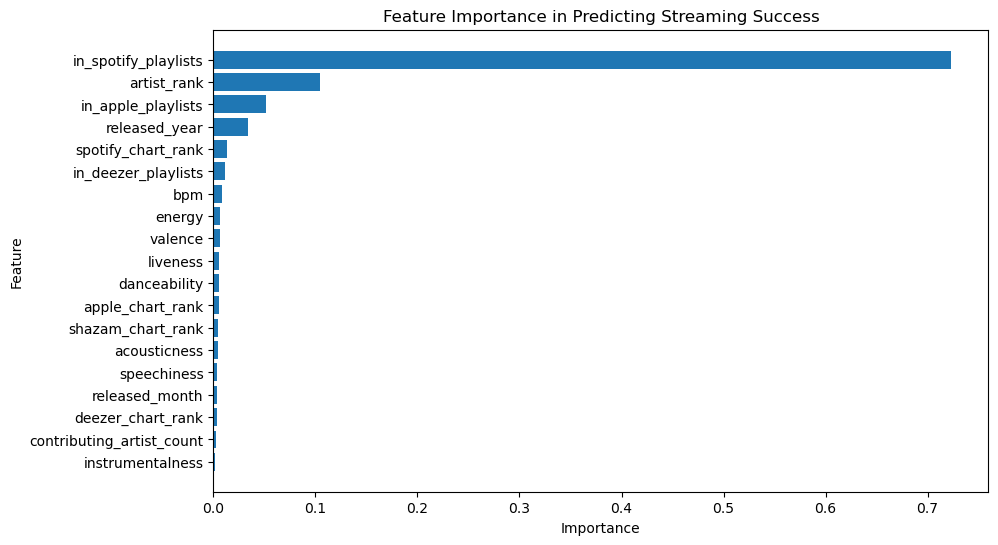

In [284]:
# Extract feature importances
importances = rf.feature_importances_

# Create a DataFrame to associate features with their importance
feature_names = X_train.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting Streaming Success')
plt.gca().invert_yaxis()  
plt.show()


Mean Squared Error: 5.080335316340035e+16
Root Mean Squared Error: 225395991.89737236
Mean Absolute Error: 135679724.37054268
R² Score: 0.7442339900049055


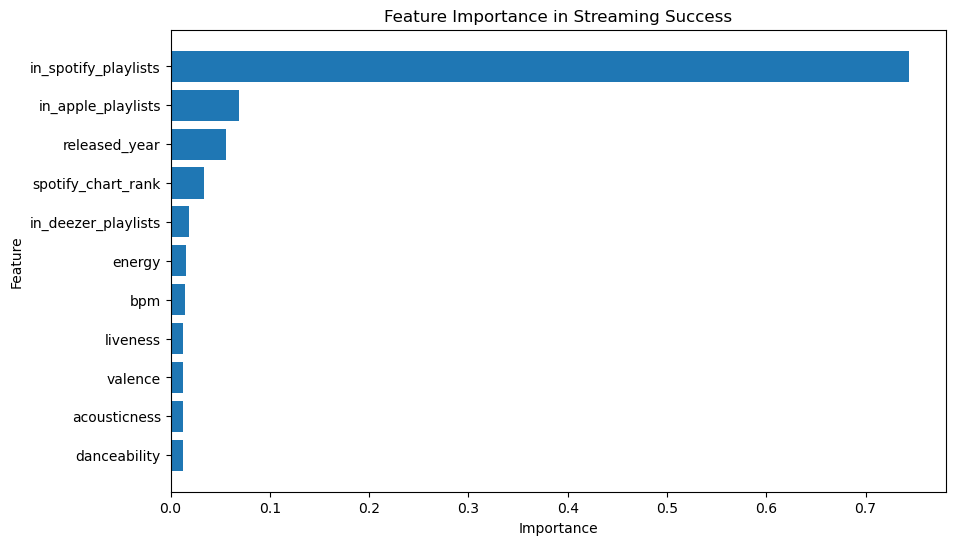

In [285]:
# Assuming 'cleaned_spotify_df' is your DataFrame
X = sorted_spotify_df[['in_spotify_playlists', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable
y = sorted_spotify_df['streams']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Step 3: Scale the numeric columns (no non-numeric columns included now)
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 5: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 6: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Step 7: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_train.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Streaming Success')
plt.gca().invert_yaxis()  
plt.show()


Mean Squared Error: 6197435.931239188
Root Mean Squared Error: 2489.4649889562993
Mean Absolute Error: 1383.8502012195122
R² Score: 0.8064754495703228


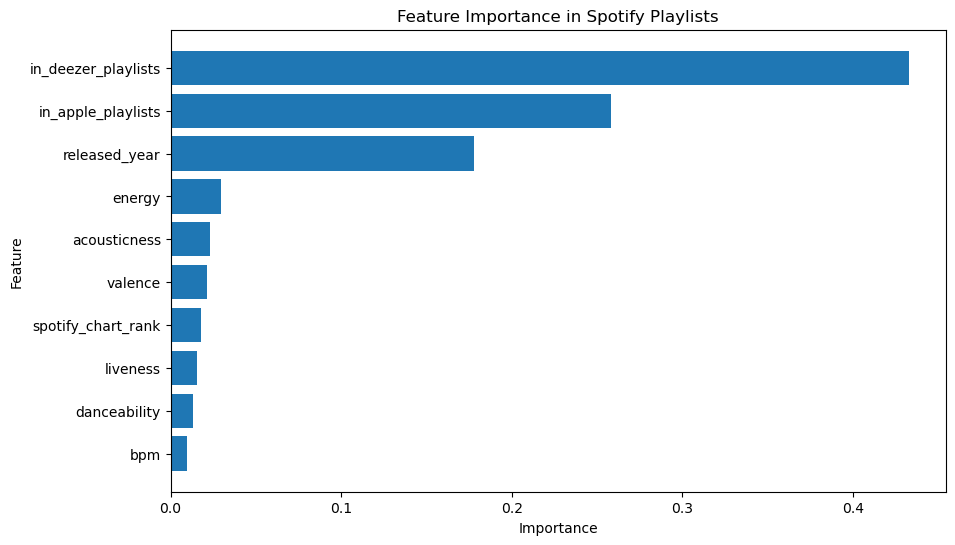

In [286]:
# Exclude 'key', 'mode', and target columns like 'streams', 'track_name', 'artists_name', etc.
X = sorted_spotify_df[[ 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable is now 'in_spotify_playlists'
y = sorted_spotify_df['in_spotify_playlists']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Step 3: Scale the numeric columns
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 5: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 6: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Step 7: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X.columns  # Use X to retain original feature names
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Spotify Playlists')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


Mean Squared Error: 38286577.02370432
Root Mean Squared Error: 6187.61480893117
Mean Absolute Error: 4491.073981707316
R² Score: -0.1955577577906591


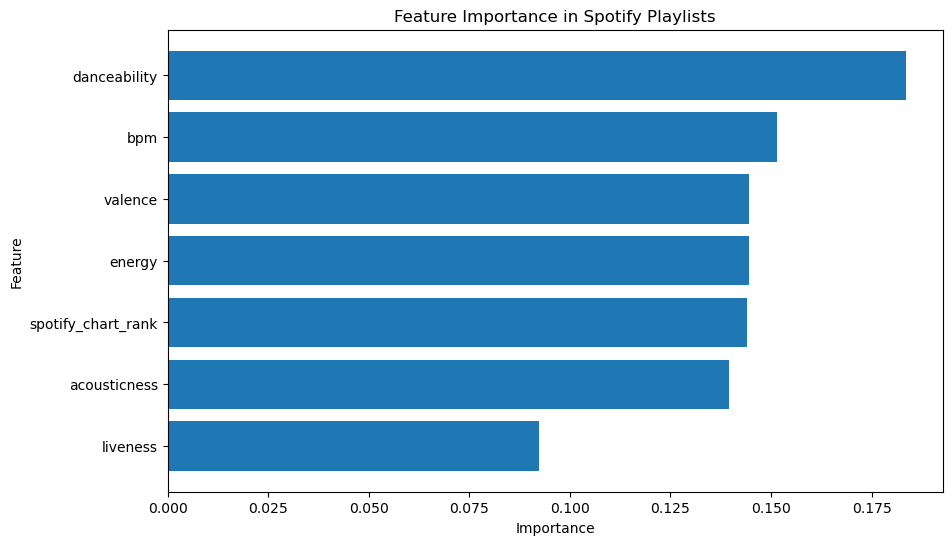

In [287]:
# Exclude 'key', 'mode', and target columns like 'streams', 'track_name', 'artists_name', etc.
X = sorted_spotify_df[[ 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable is now 'in_spotify_playlists'
y = sorted_spotify_df['in_spotify_playlists']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Step 3: Scale the numeric columns
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 5: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 6: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Step 7: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X.columns  # Use X to retain original feature names
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Spotify Playlists')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


Mean Squared Error: 7470938.808965151
Root Mean Squared Error: 2733.30181446637
Mean Absolute Error: 1480.6130845141306
R² Score: 0.7667083467527648


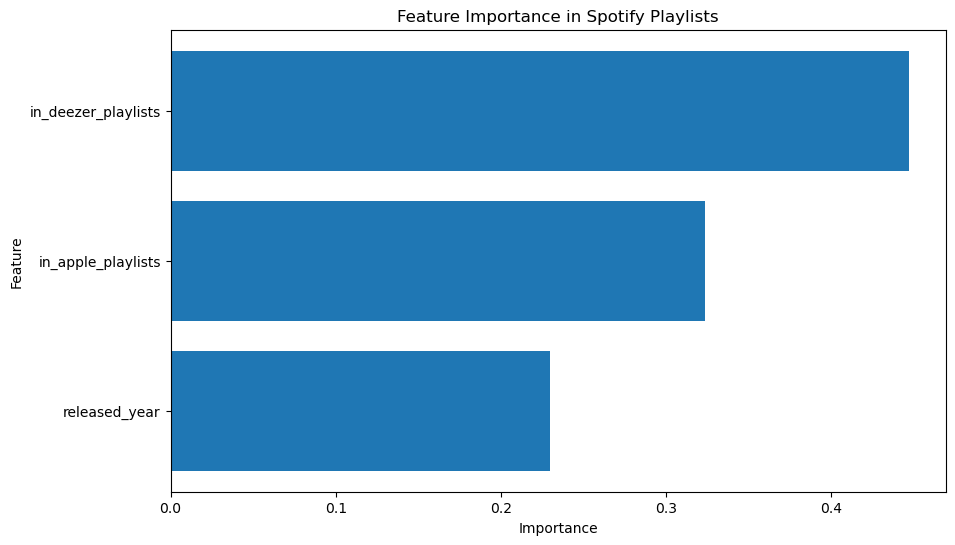

In [288]:
# Exclude 'key', 'mode', and target columns like 'streams', 'track_name', 'artists_name', etc.
X = sorted_spotify_df[['in_apple_playlists', 'released_year', 
                        'in_deezer_playlists']]

# Target variable is now 'in_spotify_playlists'
y = sorted_spotify_df['in_spotify_playlists']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Step 3: Scale the numeric columns
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 5: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 6: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Step 7: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X.columns  # Use X to retain original feature names
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Spotify Playlists')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


Mean Squared Error: 5.854923206819889e+16
Root Mean Squared Error: 241969485.82042092
Mean Absolute Error: 171029138.3971629
R² Score: 0.7052378919518201


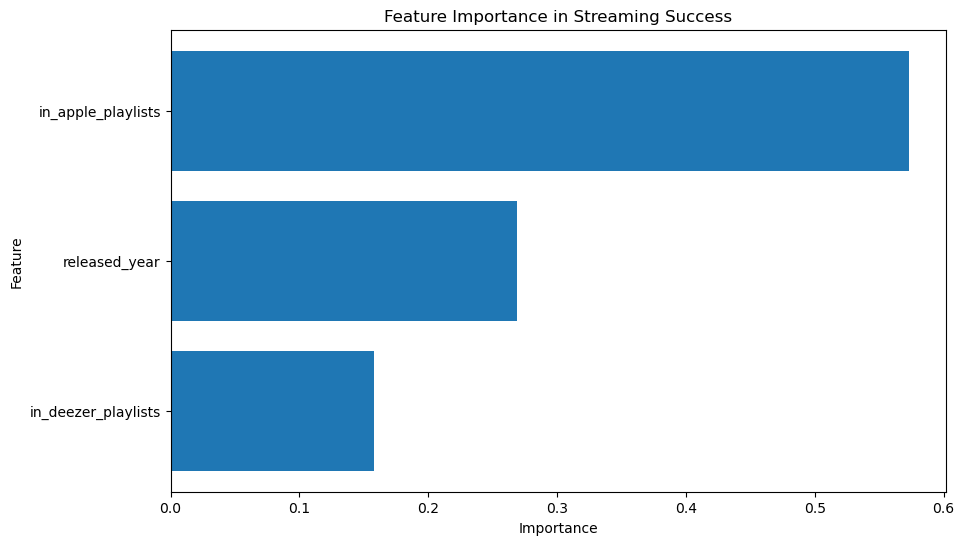

In [289]:
# Exclude 'key', 'mode', and target columns like 'streams', 'track_name', 'artists_name', etc.
X = sorted_spotify_df[['in_apple_playlists', 'released_year', 
                        'in_deezer_playlists']]

# Target variable is now 'in_spotify_playlists'
y = sorted_spotify_df['streams']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Step 3: Scale the numeric columns
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 5: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 6: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Step 7: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X.columns  # Use X to retain original feature names
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Streaming Success')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


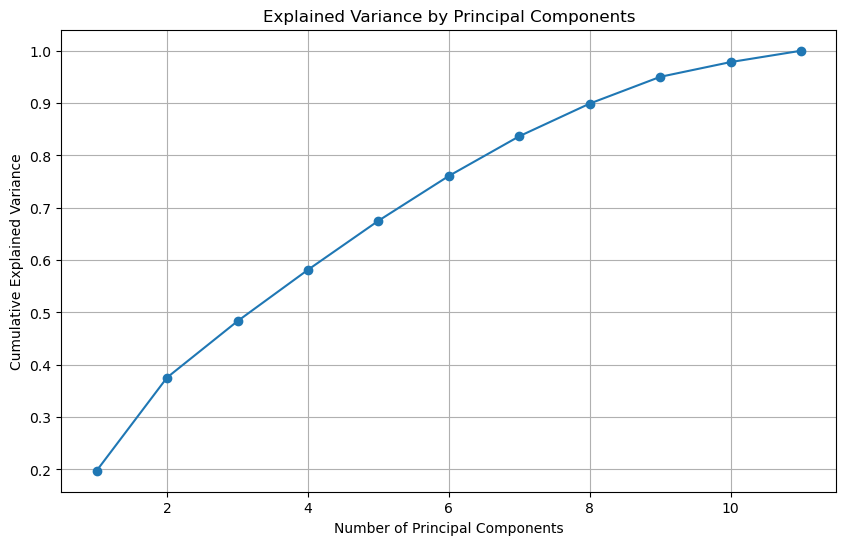

Explained Variance for each component: [0.19757742 0.17808669 0.10770683 0.09813103 0.09369008 0.08562117
 0.07586146 0.06240246 0.05106489 0.02820044 0.02165755]


In [290]:
# Step 1: Select the features for PCA (excluding non-numeric columns like 'track_name', 'artists_name', etc.)
X = sorted_spotify_df[['in_spotify_playlists', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Step 2: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA to the scaled data
pca = PCA(n_components=None)  # Keep all components
X_pca = pca.fit_transform(X_scaled)

# Step 4: Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Step 5: Display PCA results (optional, to see how much variance each component explains)
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance for each component: {explained_variance}")


Mean Squared Error: 1.1000697083682379e+17
Root Mean Squared Error: 331672987.8009721
Mean Absolute Error: 207015728.89111587
R² Score: 0.4461774223428455


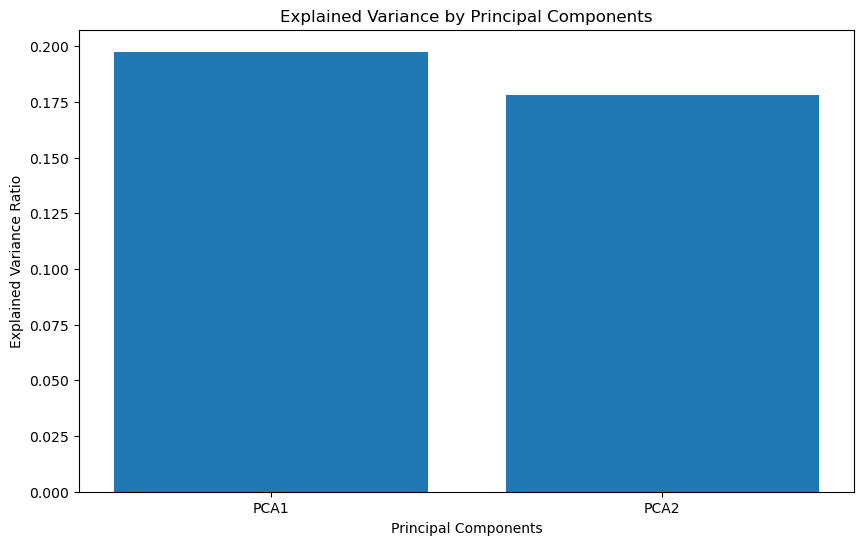

In [291]:
# Step 1: Select the features for PCA (excluding non-numeric columns like 'track_name', 'artists_name', etc.)
X = sorted_spotify_df[['in_spotify_playlists', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable is 'streams'
y = sorted_spotify_df['streams']

# Step 2: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 4: Combine PCA components into a new DataFrame
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])

# Step 5: Split the PCA data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_df, y, test_size=0.2, random_state=7)

# Step 6: Train the RandomForestRegressor using the PCA components as features
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train, y_train)

# Step 7: Make predictions on the test set
y_pred = rf.predict(X_test)

# Step 8: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Step 9: Feature importance is not applicable here since we are using PCA components
# However, if you want to plot the explained variance of the PCA components:
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.bar(['PCA1', 'PCA2'], explained_variance)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.show()


Mean Squared Error: 5.901019824735668e+16
Root Mean Squared Error: 242920147.88270792
Mean Absolute Error: 164277111.67740244
R² Score: 0.7029171892216938


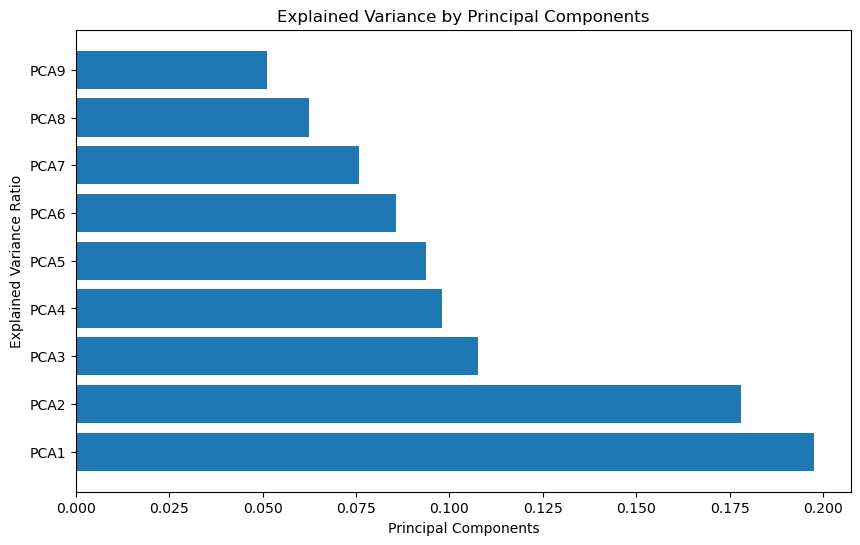

In [292]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Select the features for PCA (excluding non-numeric columns like 'track_name', 'artists_name', etc.)
X = sorted_spotify_df[['in_spotify_playlists', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable is 'streams'
y = sorted_spotify_df['streams']

# Step 2: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA with 2 components
pca = PCA(n_components=9)
X_pca = pca.fit_transform(X_scaled)

# Step 4: Combine PCA components into a new DataFrame
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9'])

# Step 5: Split the PCA data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_df, y, test_size=0.2, random_state=7)

# Step 6: Train the RandomForestRegressor using the PCA components as features
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train, y_train)

# Step 7: Make predictions on the test set
y_pred = rf.predict(X_test)

# Step 8: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Step 9: Plot the explained variance of all PCA components
explained_variance = pca.explained_variance_ratio_

# Create labels for all 9 components
pca_labels = [f'PCA{i+1}' for i in range(len(explained_variance))]

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.barh(pca_labels, explained_variance)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.grid(False)
plt.show()



In [293]:
# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['in_spotify_playlists', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF results
print(vif_data)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Step 4: Scale the numeric columns (no non-numeric columns included)
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 8: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)


                 Feature        VIF
0   in_spotify_playlists   2.721887
1     in_apple_playlists   3.691466
2          released_year  93.757499
3    in_deezer_playlists   1.614651
4     spotify_chart_rank   1.479729
5                valence   8.156319
6                 energy  29.623761
7           danceability  30.395958
8                    bpm  20.818461
9               liveness   2.907379
10          acousticness   3.328847


Mean Squared Error: 4.39162546366752e+16
Root Mean Squared Error: 209562054.3816919
Mean Absolute Error: 145289427.06163415
R² Score: 0.7838465240353043


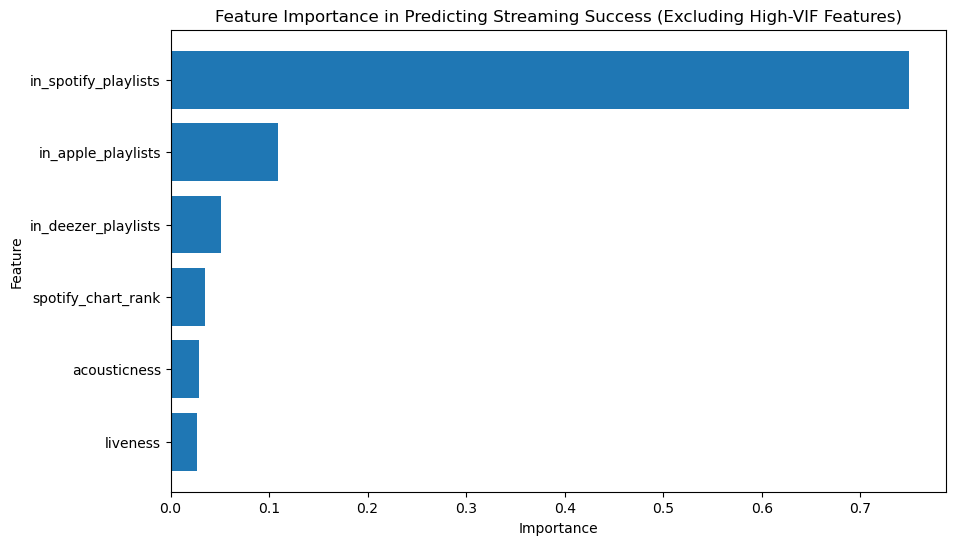

In [294]:
# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['in_spotify_playlists', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X.drop(columns=high_vif_features)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 4: Scale the numeric columns (no non-numeric columns included)
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 7: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Step 8: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 9: Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting Streaming Success (Excluding High-VIF Features)')
plt.gca().invert_yaxis()  
plt.show()


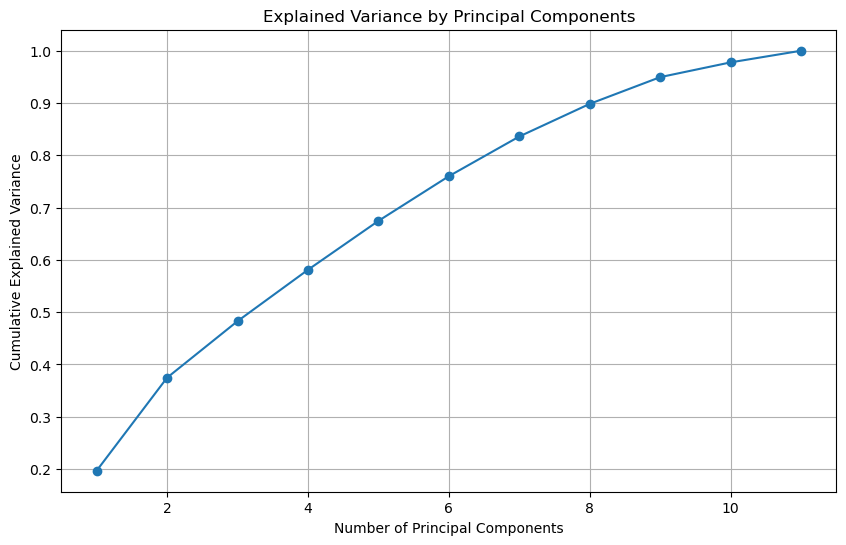

Explained Variance for each component: [0.19677437 0.17789246 0.10813418 0.09826169 0.09352766 0.08549186
 0.07595266 0.06239415 0.05109539 0.02822786 0.02224771]


In [295]:
# Step 1: Select the features for PCA (excluding non-numeric columns like 'track_name', 'artists_name', etc.)
X = cleaned_spotify_df[['in_spotify_playlists', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Step 2: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA to the scaled data
pca = PCA(n_components=None)  # Keep all components
X_pca = pca.fit_transform(X_scaled)

# Step 4: Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Step 5: Display PCA results (optional, to see how much variance each component explains)
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance for each component: {explained_variance}")


c:\Users\npwol\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\npwol\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


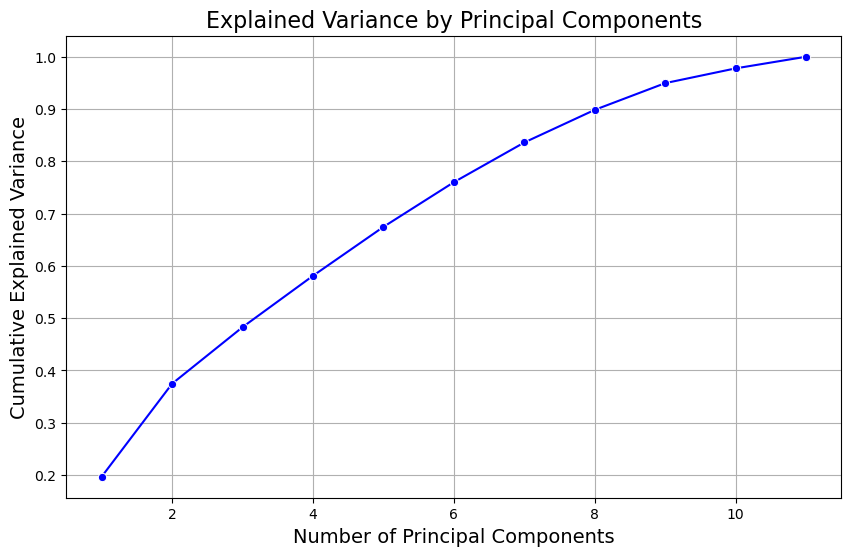

Explained Variance for each component: [0.19677437 0.17789246 0.10813418 0.09826169 0.09352766 0.08549186
 0.07595266 0.06239415 0.05109539 0.02822786 0.02224771]


In [296]:
import seaborn as sns

# Step 1: Select the features for PCA (excluding non-numeric columns like 'track_name', 'artists_name', etc.)
X = cleaned_spotify_df[['in_spotify_playlists', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Step 2: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA to the scaled data
pca = PCA(n_components=None)  # Keep all components
X_pca = pca.fit_transform(X_scaled)

# Step 4: Plot the explained variance ratio using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(pca.explained_variance_ratio_) + 1), 
             y=pca.explained_variance_ratio_.cumsum(), 
             marker='o', 
             color='b')
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)
plt.title('Explained Variance by Principal Components', fontsize=16)
plt.grid(True)
plt.show()

# Step 5: Display PCA results (optional, to see how much variance each component explains)
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance for each component: {explained_variance}")


Mean Squared Error: 4.39162546366752e+16
Root Mean Squared Error: 209562054.3816919
Mean Absolute Error: 145289427.06163415
R² Score: 0.7838465240353043


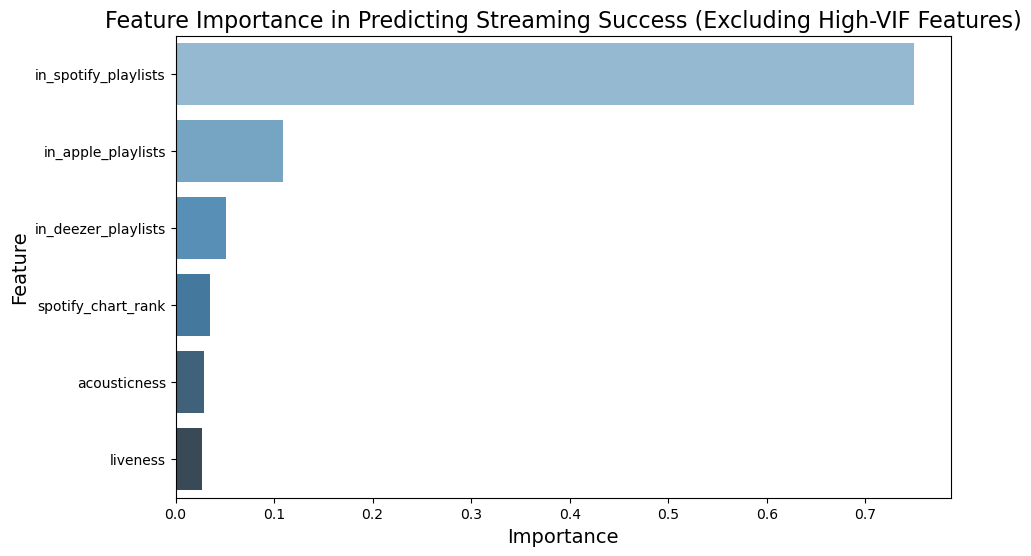

In [297]:
# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['in_spotify_playlists', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X.drop(columns=high_vif_features)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 4: Scale the numeric columns (no non-numeric columns included)
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 7: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Step 8: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 9: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in Predicting Streaming Success (Excluding High-VIF Features)', fontsize=16)
plt.show()


R² Score: 0.8405638827954625


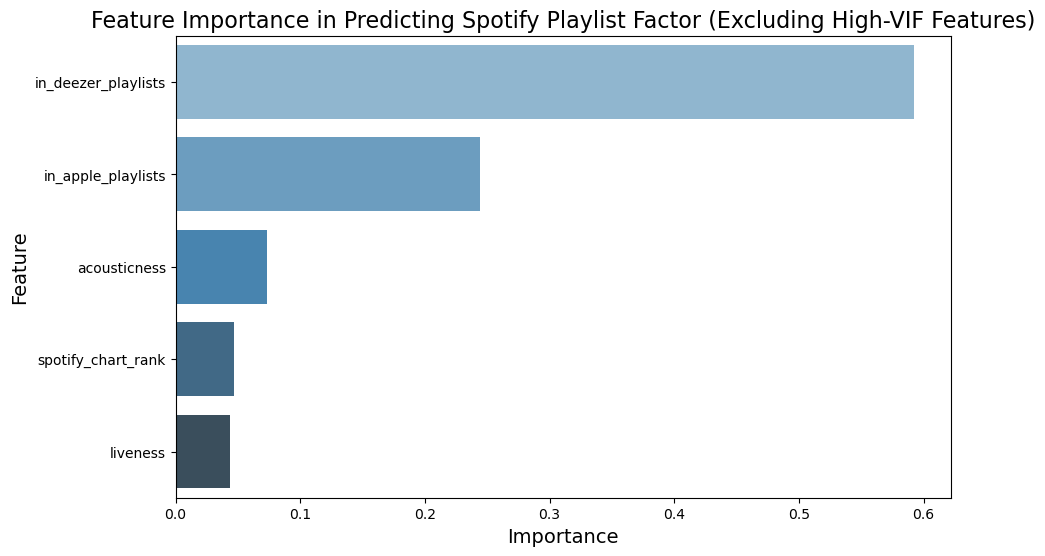

In [298]:
# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable
y = cleaned_spotify_df['in_spotify_playlists']

# Step 2: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X.drop(columns=high_vif_features)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 4: Scale the numeric columns (no non-numeric columns included)
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 7: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"R² Score: {r2}")

# Step 8: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 9: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in Predicting Spotify Playlist Factor (Excluding High-VIF Features)', fontsize=16)
plt.show()


Mean Squared Error: 10833938.476359751
Root Mean Squared Error: 3291.4948695630305
Mean Absolute Error: 1517.1025182926828
R² Score: 0.8309164401486038


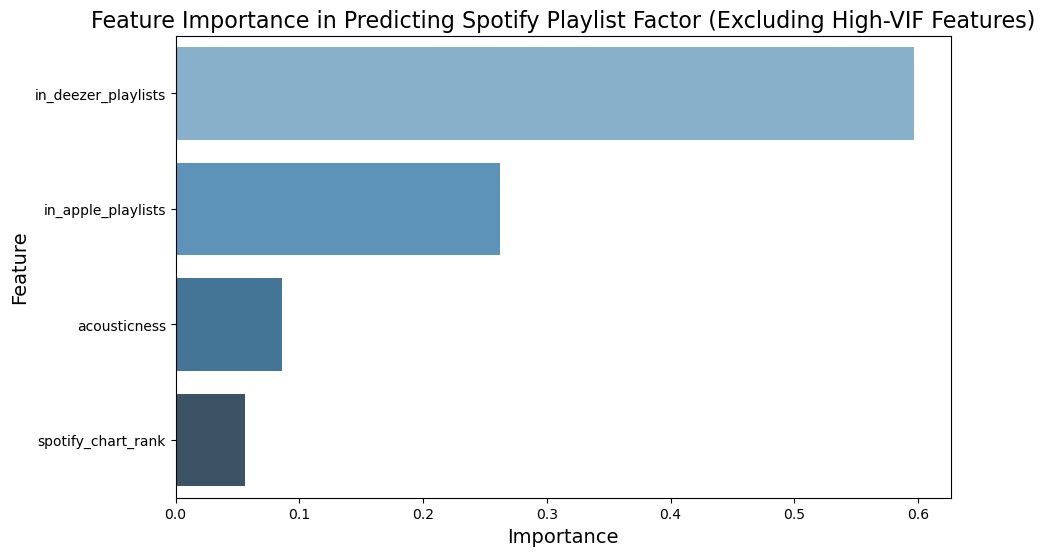

In [299]:
# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'acousticness']]

# Target variable
y = cleaned_spotify_df['in_spotify_playlists']

# Step 2: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X.drop(columns=high_vif_features)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 4: Scale the numeric columns (no non-numeric columns included)
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 7: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Step 8: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 9: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in Predicting Spotify Playlist Factor (Excluding High-VIF Features)', fontsize=16)
plt.show()


Mean Squared Error: 8616041.30574042
Root Mean Squared Error: 2935.309405452928
Mean Absolute Error: 1652.467786585366
R² Score: 0.7309507450053556


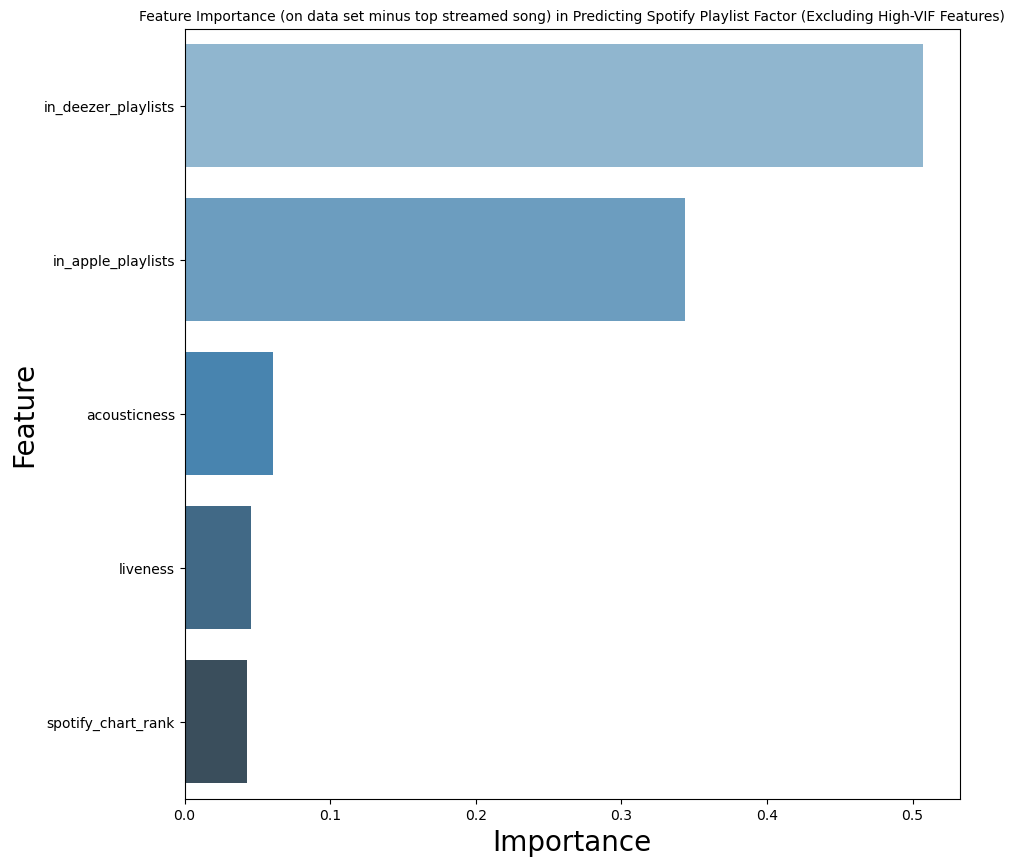

In [300]:
# Step 1: Select the features for VIF calculation and model training
X = sorted_spotify_df[['in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable
y = sorted_spotify_df['in_spotify_playlists']

# Step 2: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X.drop(columns=high_vif_features)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 4: Scale the numeric columns (no non-numeric columns included)
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 7: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Step 8: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 9: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.title('Feature Importance (on data set minus top streamed song) in Predicting Spotify Playlist Factor (Excluding High-VIF Features)', fontsize=10)
plt.show()


Mean Squared Error: 13575150.275212305
Root Mean Squared Error: 3684.447078628258
Mean Absolute Error: 1928.115870627662
R² Score: 0.5760948748524661


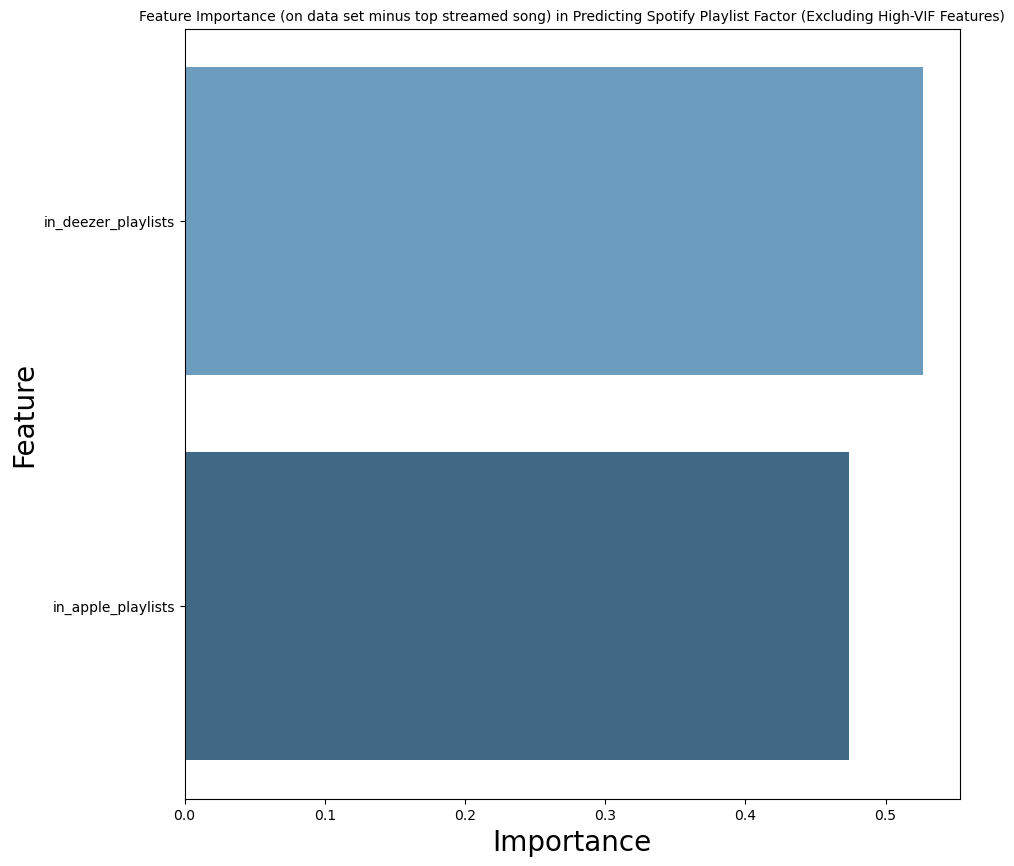

In [301]:
# Step 1: Select the features for VIF calculation and model training
X = sorted_spotify_df[['in_apple_playlists', 'in_deezer_playlists']] 

# Target variable
y = sorted_spotify_df['in_spotify_playlists']

# Step 2: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X.drop(columns=high_vif_features)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 4: Scale the numeric columns (no non-numeric columns included)
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 7: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Step 8: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 9: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.title('Feature Importance (on data set minus top streamed song) in Predicting Spotify Playlist Factor (Excluding High-VIF Features)', fontsize=10)
plt.show()


In [302]:
# Step 1: Select the features for VIF calculation and model training
X = sorted_spotify_df[['in_apple_playlists', 'in_deezer_playlists', 'spotify_chart_rank',
                        'liveness', 'acousticness']]

# Target variable
y = sorted_spotify_df['in_spotify_playlists']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Scale the numeric columns using StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and apply it to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [303]:
import tensorflow as tf

# Define the model
nn = tf.keras.models.Sequential()

# Input layer and first hidden layer
nn.add(tf.keras.layers.Dense(units=400, activation='relu', input_dim=X_train_scaled.shape[1]))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=4, activation='relu'))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=100, activation='relu'))

# Output layer (since we're predicting `streams` - a continuous value)
nn.add(tf.keras.layers.Dense(units=1, activation='linear'))  

# Compile the model
nn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])


c:\Users\npwol\anaconda3\envs\dev\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [304]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

6/6 - 1s - 118ms/step - loss: 48542004.0000 - mse: 48542004.0000
Loss: 48542004.0, Accuracy: 48542004.0


In [305]:
# Evaluate the model's performance on the test data
test_loss, test_mse = nn.evaluate(X_test_scaled, y_test)

# Predict on the test set
y_pred = nn.predict(X_test_scaled)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 50851496.0000 - mse: 50851496.0000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Mean Squared Error: 48542005.89853574
Root Mean Squared Error: 6967.209333623882
Mean Absolute Error: 4064.225709989272
R² Score: -0.5157994326519015


In [306]:
# Train the model
history = nn.fit(X_train_scaled, y_train, epochs=125, batch_size=32, validation_data=(X_test_scaled, y_test))


Epoch 1/125


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 78159880.0000 - mse: 78159880.0000 - val_loss: 48539284.0000 - val_mse: 48539284.0000
Epoch 2/125
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 84915408.0000 - mse: 84915408.0000 - val_loss: 48527240.0000 - val_mse: 48527240.0000
Epoch 3/125
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 110758832.0000 - mse: 110758832.0000 - val_loss: 48487628.0000 - val_mse: 48487628.0000
Epoch 4/125
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 89705632.0000 - mse: 89705632.0000 - val_loss: 48382824.0000 - val_mse: 48382824.0000
Epoch 5/125
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 94380576.0000 - mse: 94380576.0000 - val_loss: 48144720.0000 - val_mse: 48144720.0000
Epoch 6/125
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 94406016.0000 - mse: 94406016.0000 - val_loss: 47666328.0000 - val_mse: 47666328.0000
Epoch 7/125
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 77282376.0000 - mse: 77282376.0000 - val_loss: 46823876.0000 - val_mse: 46823

In [307]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

6/6 - 0s - 14ms/step - loss: 16566260.0000 - mse: 16566260.0000
Loss: 16566260.0, Accuracy: 16566260.0


In [308]:
# Evaluate the model's performance on the test data
test_loss, test_mse = nn.evaluate(X_test_scaled, y_test)

# Predict on the test set
y_pred = nn.predict(X_test_scaled)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 18619696.0000 - mse: 18619696.0000 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Mean Squared Error: 16566259.268286612
Root Mean Squared Error: 4070.1669828505333
Mean Absolute Error: 2470.506986932057
R² Score: 0.4826928567286375


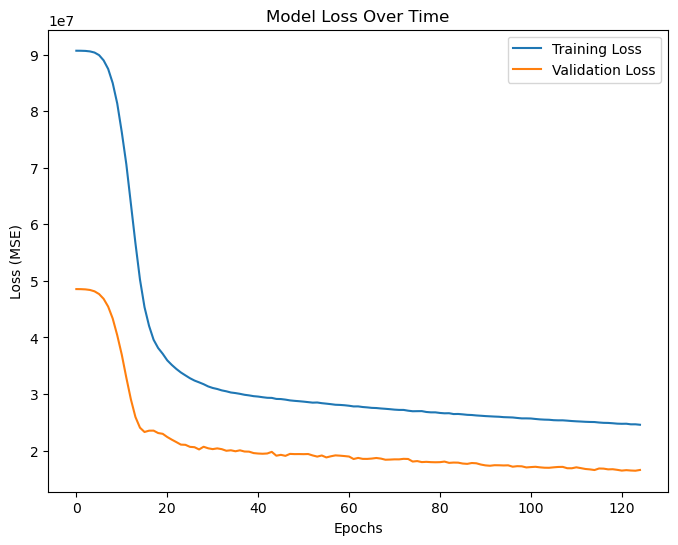

In [309]:
# Plot training and validation loss
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss Over Time')
plt.legend()
plt.show()


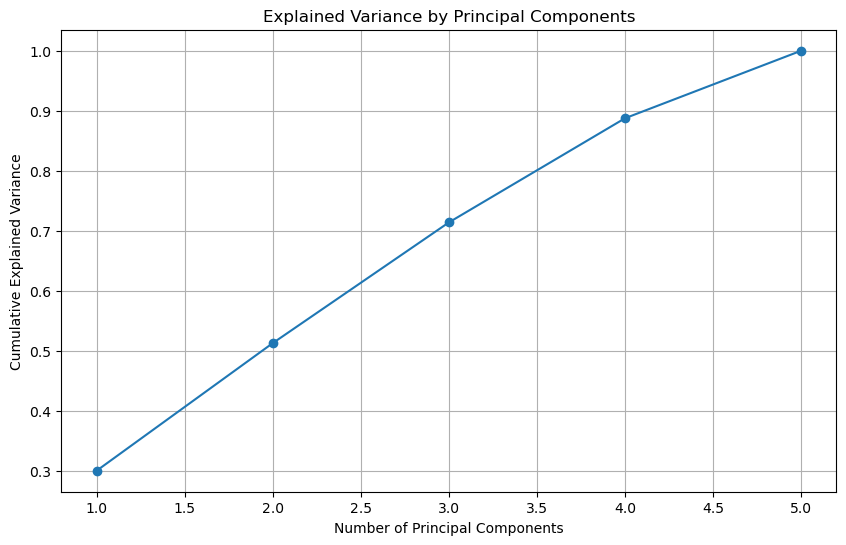

Mean Squared Error: 13668120.090118792
Root Mean Squared Error: 3697.042073079341
Mean Absolute Error: 2161.4856341463415
R² Score: 0.5731917481670226


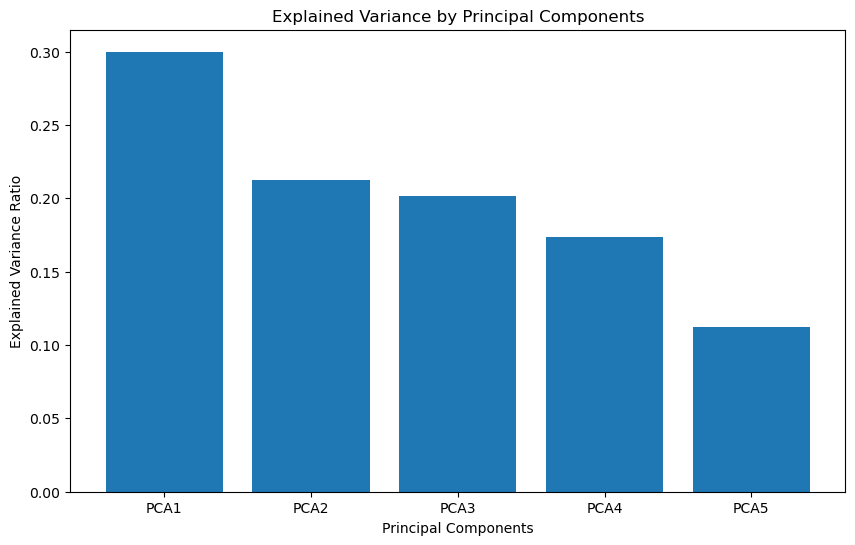

In [310]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Select the features for PCA (VIF calculation and model training)
X = sorted_spotify_df[['in_apple_playlists', 'in_deezer_playlists', 'spotify_chart_rank',
                        'liveness', 'acousticness']]

# Target variable is 'in_spotify_playlists'
y = sorted_spotify_df['in_spotify_playlists']

# Step 2: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA (you can adjust 'n_components' to the number of components you'd like to keep)
pca = PCA(n_components=None)  # Keep all components initially
X_pca = pca.fit_transform(X_scaled)

# Step 4: Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Step 5: Apply PCA with a reduced number of components based on explained variance
# Here, we'll keep enough components that explain most of the variance (e.g., 2 or 3 components)
pca = PCA(n_components=5)  # You can adjust this number based on the cumulative explained variance plot
X_pca_reduced = pca.fit_transform(X_scaled)

# Step 6: Combine PCA components into a new DataFrame
pca_df = pd.DataFrame(X_pca_reduced, columns=[f'PCA{i+1}' for i in range(X_pca_reduced.shape[1])])

# Step 7: Split the PCA data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_df, y, test_size=0.2, random_state=7)

# Step 8: Train the RandomForestRegressor using the PCA components as features
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train, y_train)

# Step 9: Make predictions on the test set
y_pred = rf.predict(X_test)

# Step 10: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Step 11: Plot the explained variance of the PCA components
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.bar([f'PCA{i+1}' for i in range(len(explained_variance))], explained_variance)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.grid(False)
plt.show()


R² Score: 0.08208100749380276


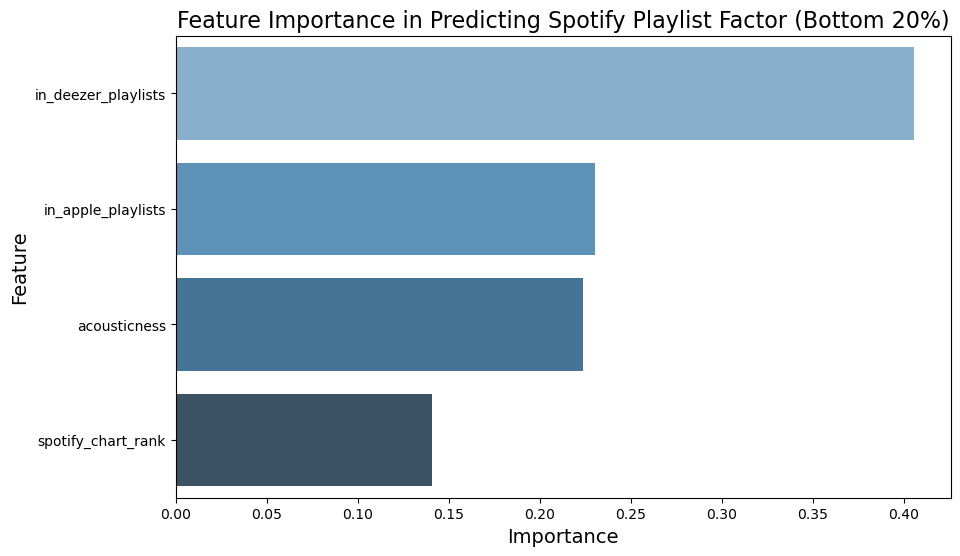

R² Score: -0.1369039699586625


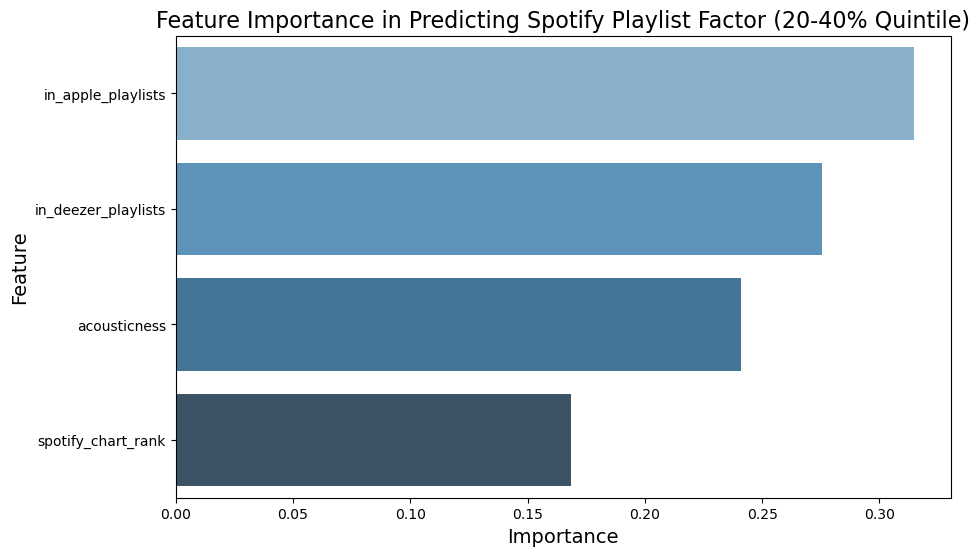

R² Score: -0.04930595616365996


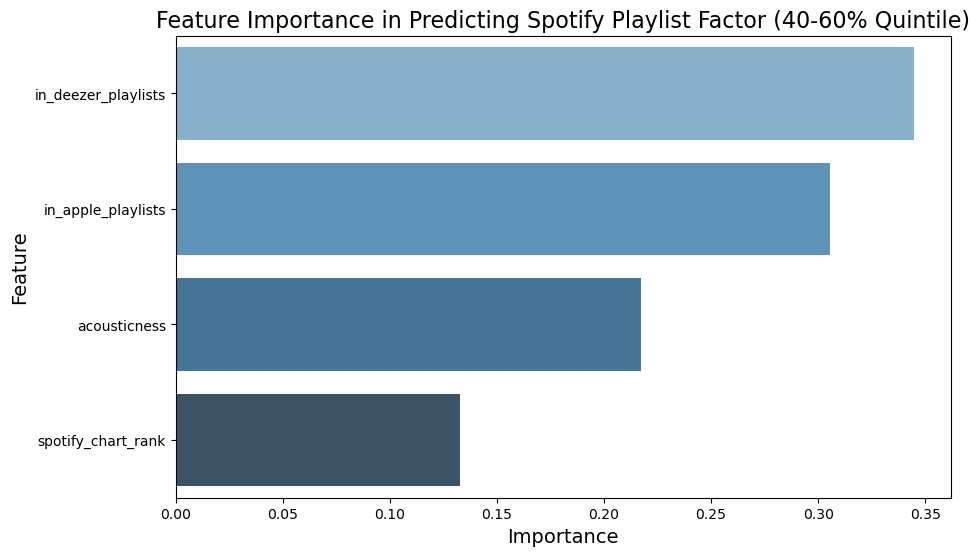

R² Score: 0.1255899320415701


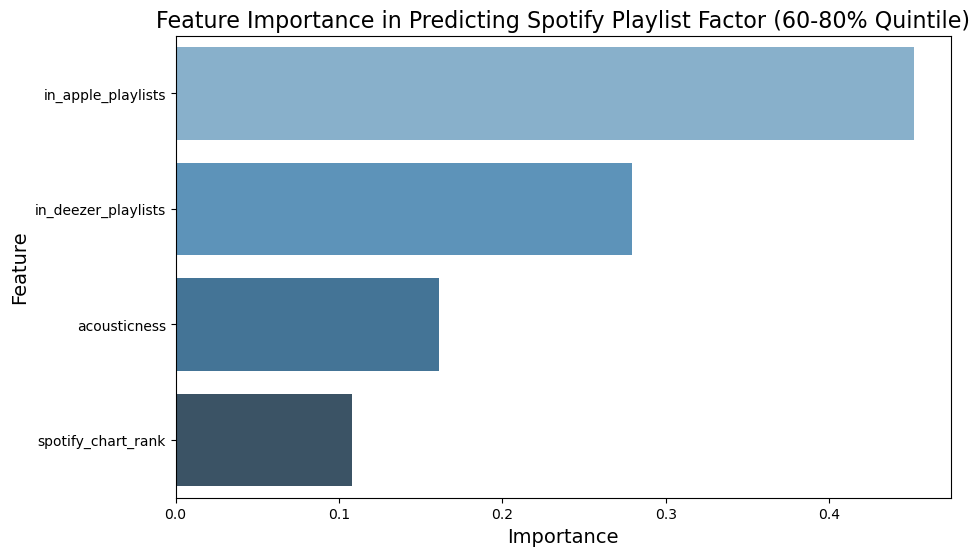

R² Score: 0.5371085860470959


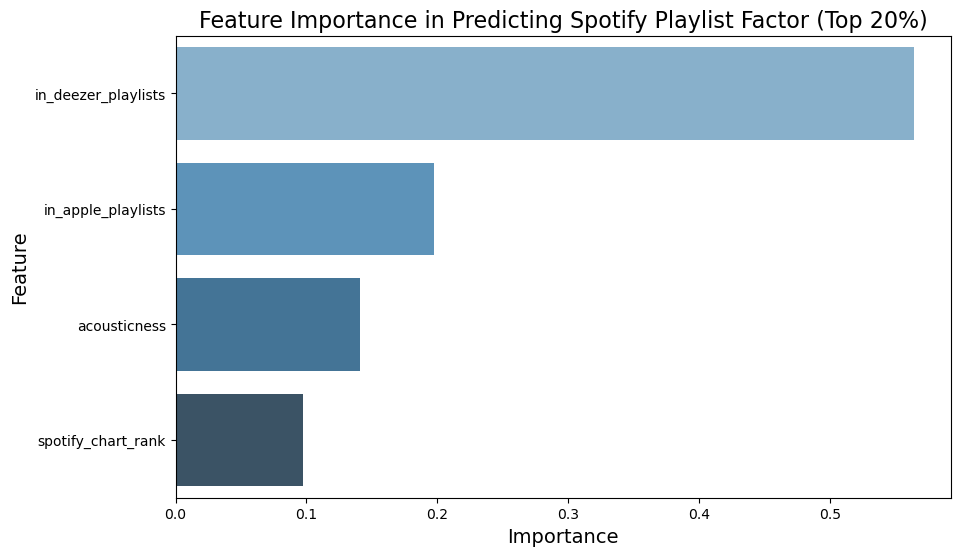

In [311]:
# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'acousticness']]

# Target variable
y = cleaned_spotify_df['in_spotify_playlists']

# Step 2: Define quintiles
bottom_20_threshold = y.quantile(0.20)
middle_40_threshold_low = y.quantile(0.40)
middle_40_threshold_high = y.quantile(0.60)
top_20_threshold = y.quantile(0.80)

# Step 3: Create dictionaries to store results for each quintile
results = {}

# Function to run the analysis for a specific quintile
def run_analysis_for_quintile(X, y, quintile_name):
    # Step 4: Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Filter out features with VIF > 5
    high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
    X_filtered = X.drop(columns=high_vif_features)

    # Step 5: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

    # Step 6: Scale the numeric columns
    scaler = StandardScaler()

    # Fit the scaler on X_train and apply the transformation to both training and testing sets
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Step 7: Train the RandomForestRegressor
    rf = RandomForestRegressor(n_estimators=1000, random_state=7)
    rf.fit(X_train_scaled, y_train)

    # Step 8: Make predictions on the test set
    y_pred = rf.predict(X_test_scaled)

    # Step 9: Calculate regression metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mse ** 0.5

    # Print the R² and other metrics for the current quintile
    print(f"R² Score: {r2}")

    # Step 10: Evaluate feature importance
    importances = rf.feature_importances_
    feature_names = X_filtered.columns  
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

    # Sort by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Store the results for this quintile
    results[quintile_name] = {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2,
        "Importance": importance_df
    }

    # Step 11: Plot the feature importances using Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.title(f'Feature Importance in Predicting Spotify Playlist Factor ({quintile_name})', fontsize=16)
    plt.show()

# Step 12: Filter and run analysis for each quintile

# Bottom 20% (quintile 1)
X_bottom_20 = X[y <= bottom_20_threshold]
y_bottom_20 = y[y <= bottom_20_threshold]
run_analysis_for_quintile(X_bottom_20, y_bottom_20, "Bottom 20%")

# Middle 20-40% (quintile 2)
X_middle_20_40 = X[(y > bottom_20_threshold) & (y <= middle_40_threshold_low)]
y_middle_20_40 = y[(y > bottom_20_threshold) & (y <= middle_40_threshold_low)]
run_analysis_for_quintile(X_middle_20_40, y_middle_20_40, "20-40% Quintile")

# Middle 40-60% (quintile 3)
X_middle_40_60 = X[(y > middle_40_threshold_low) & (y <= middle_40_threshold_high)]
y_middle_40_60 = y[(y > middle_40_threshold_low) & (y <= middle_40_threshold_high)]
run_analysis_for_quintile(X_middle_40_60, y_middle_40_60, "40-60% Quintile")

# Middle 60-80% (quintile 4)
X_middle_60_80 = X[(y > middle_40_threshold_high) & (y <= top_20_threshold)]
y_middle_60_80 = y[(y > middle_40_threshold_high) & (y <= top_20_threshold)]
run_analysis_for_quintile(X_middle_60_80, y_middle_60_80, "60-80% Quintile")

# Top 20% (quintile 5)
X_top_20 = X[y > top_20_threshold]
y_top_20 = y[y > top_20_threshold]
run_analysis_for_quintile(X_top_20, y_top_20, "Top 20%")


R² Score: 0.8405638827954625


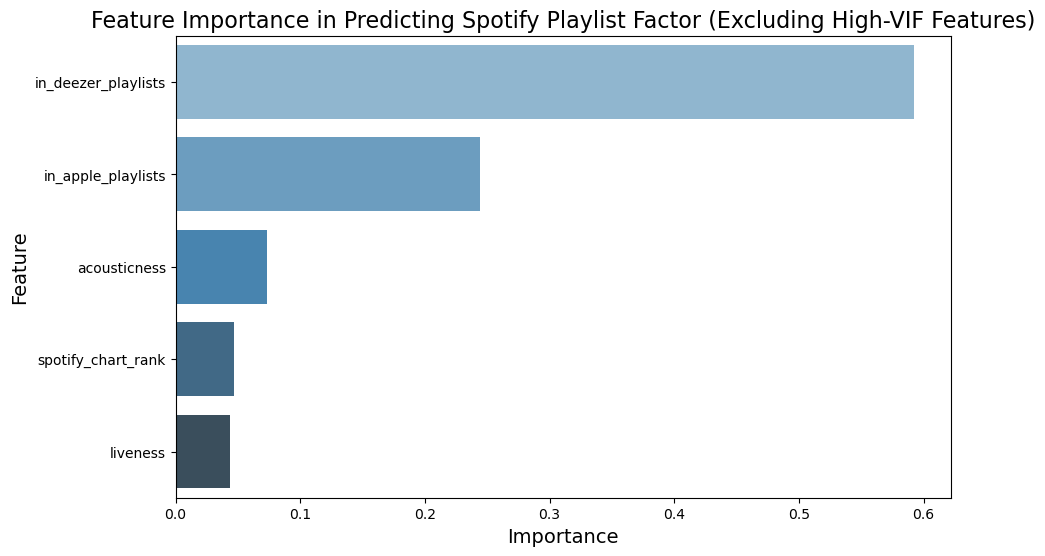

In [312]:
# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable
y = cleaned_spotify_df['in_spotify_playlists']

# Step 2: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X.drop(columns=high_vif_features)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 4: Scale the numeric columns (no non-numeric columns included)
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 7: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"R² Score: {r2}")

# Step 8: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 9: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in Predicting Spotify Playlist Factor (Excluding High-VIF Features)', fontsize=16)
plt.show()


R² Score: 0.8406625149560594


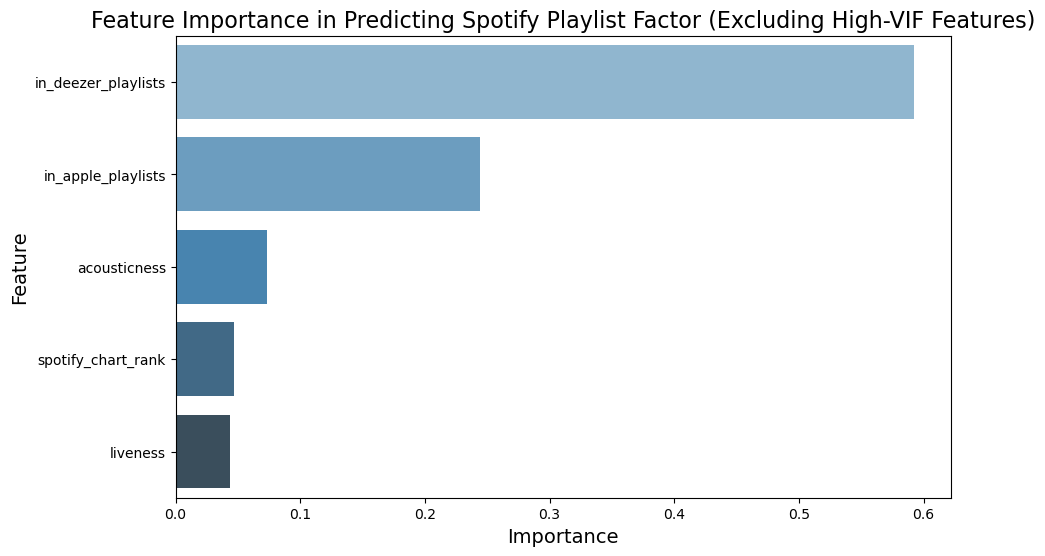

In [313]:
from sklearn.preprocessing import MinMaxScaler

# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable
y = cleaned_spotify_df['in_spotify_playlists']

# Step 2: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X.drop(columns=high_vif_features)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 4: Scale the numeric columns using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 7: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"R² Score: {r2}")

# Step 8: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 9: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in Predicting Spotify Playlist Factor (Excluding High-VIF Features)', fontsize=16)
plt.show()



R² Score: 0.08208100749380276


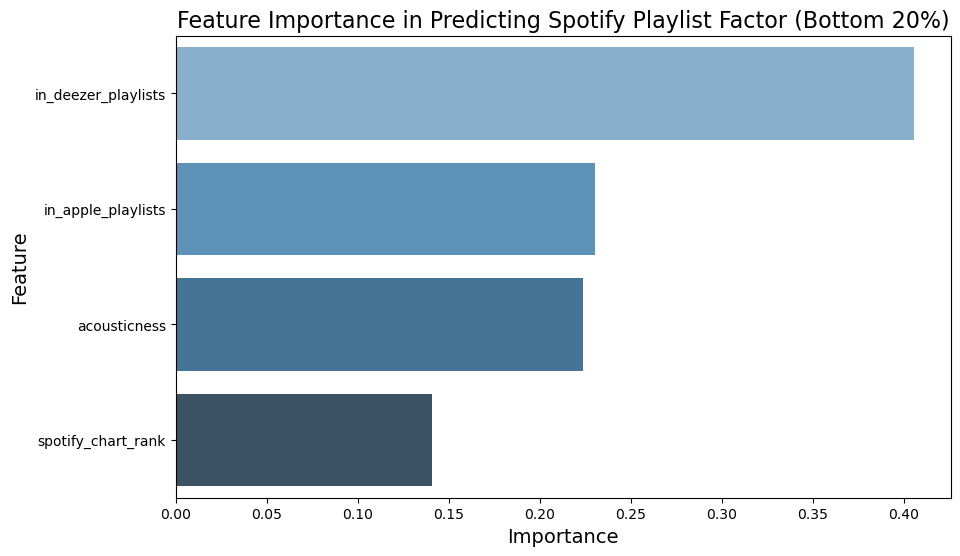

In [314]:
# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'acousticness']]

# Target variable
y = cleaned_spotify_df['in_spotify_playlists']

# Step 2: Define the bottom 20% threshold
bottom_20_threshold = y.quantile(0.20)

# Step 3: Filter the bottom 20% data
X_bottom_20 = X[y <= bottom_20_threshold]
y_bottom_20 = y[y <= bottom_20_threshold]

# Step 4: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_bottom_20.columns
vif_data["VIF"] = [variance_inflation_factor(X_bottom_20.values, i) for i in range(X_bottom_20.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X_bottom_20.drop(columns=high_vif_features)

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_bottom_20, test_size=0.2, random_state=7)

# Step 6: Scale the numeric columns
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 7: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 8: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 9: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

# Print the R² and other metrics for the bottom 20% quintile
print(f"R² Score: {r2}")

# Step 10: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 11: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title(f'Feature Importance in Predicting Spotify Playlist Factor (Bottom 20%)', fontsize=16)
plt.show()


R² Score: 0.8403236534271779


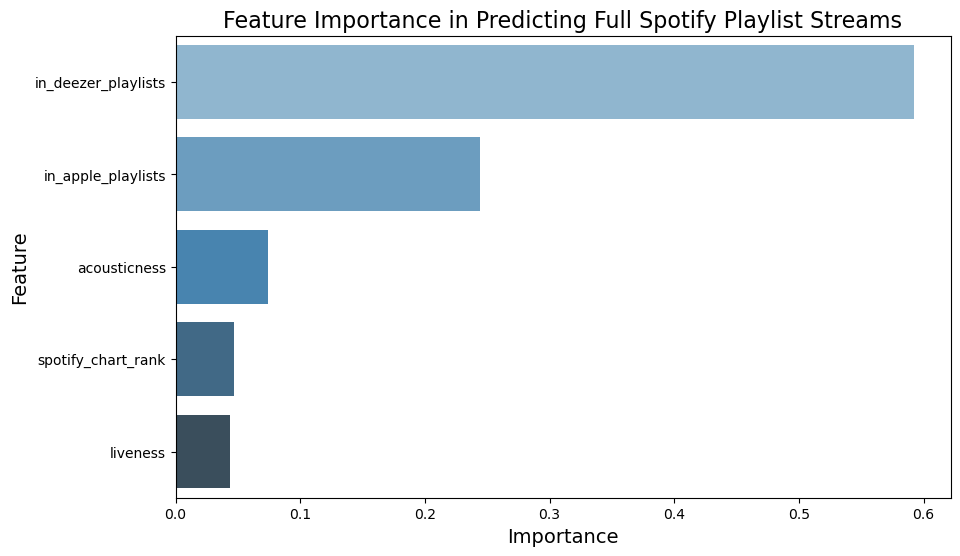

VIF Data:
               Feature        VIF
0   in_apple_playlists   2.063467
1        released_year  92.769089
2  in_deezer_playlists   1.604421
3   spotify_chart_rank   1.479711
4              valence   8.144618
5               energy  29.600161
6         danceability  30.021272
7                  bpm  20.744639
8         acousticness   3.327252
9             liveness   2.905943


In [315]:
# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'acousticness', 'liveness']]

# Step 2: Set the full `streams` target variable
y = cleaned_spotify_df['in_spotify_playlists']

# Step 3: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X.drop(columns=high_vif_features)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 5: Scale the numeric columns
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train the RandomForestRegressor to predict the full `streams`
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 7: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 8: Calculate regression metrics
r2 = r2_score(y_test, y_pred)

# Print the R² for the `streams` prediction
print(f"R² Score: {r2}")

# Step 9: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 10: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title(f'Feature Importance in Predicting Full Spotify Playlist Streams', fontsize=16)
plt.show()

# Display VIF results
print("VIF Data:")
print(vif_data)


R² Score: 0.8188750669019409


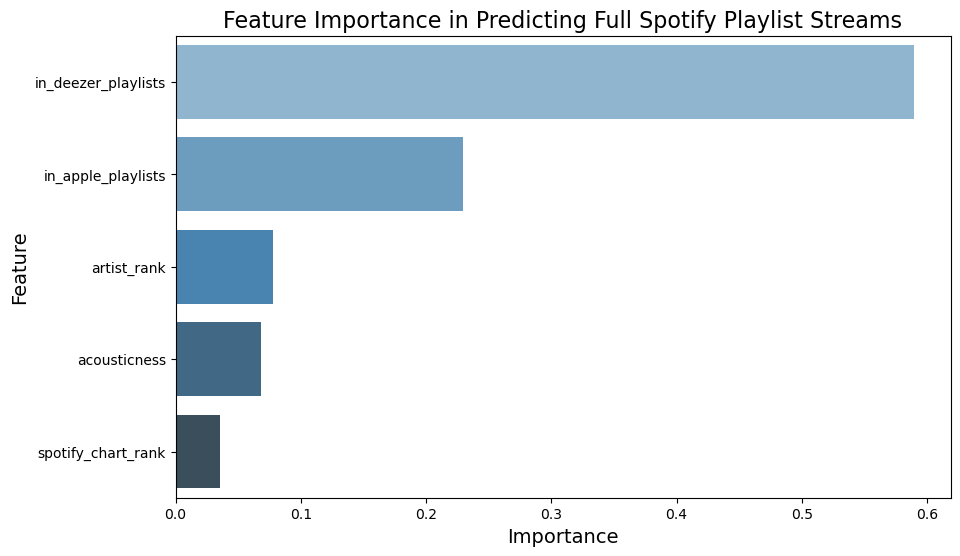

In [316]:
# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['artist_rank', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'acousticness']]

# Step 2: Set the full `streams` target variable
y = cleaned_spotify_df['in_spotify_playlists']

# Step 3: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X.drop(columns=high_vif_features)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 5: Scale the numeric columns
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train the RandomForestRegressor to predict the full `streams`
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 7: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 8: Calculate regression metrics
r2 = r2_score(y_test, y_pred)

# Print the R² for the `streams` prediction
print(f"R² Score: {r2}")

# Step 9: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 10: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title(f'Feature Importance in Predicting Full Spotify Playlist Streams', fontsize=16)
plt.show()


R² Score: 0.8406625149560594


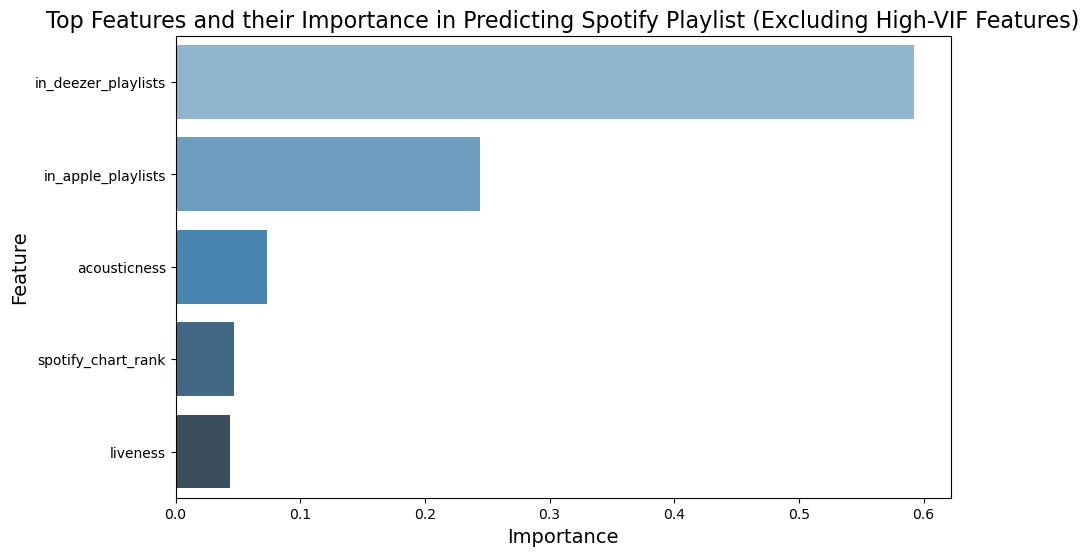

In [317]:
# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable
y = cleaned_spotify_df['in_spotify_playlists']

# Step 2: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X.drop(columns=high_vif_features)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 4: Scale the numeric columns using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 7: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"R² Score: {r2}")

# Step 8: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 9: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Top Features and their Importance in Predicting Spotify Playlist (Excluding High-VIF Features)', fontsize=16)
plt.show()



R² Score: 0.8276891529620407


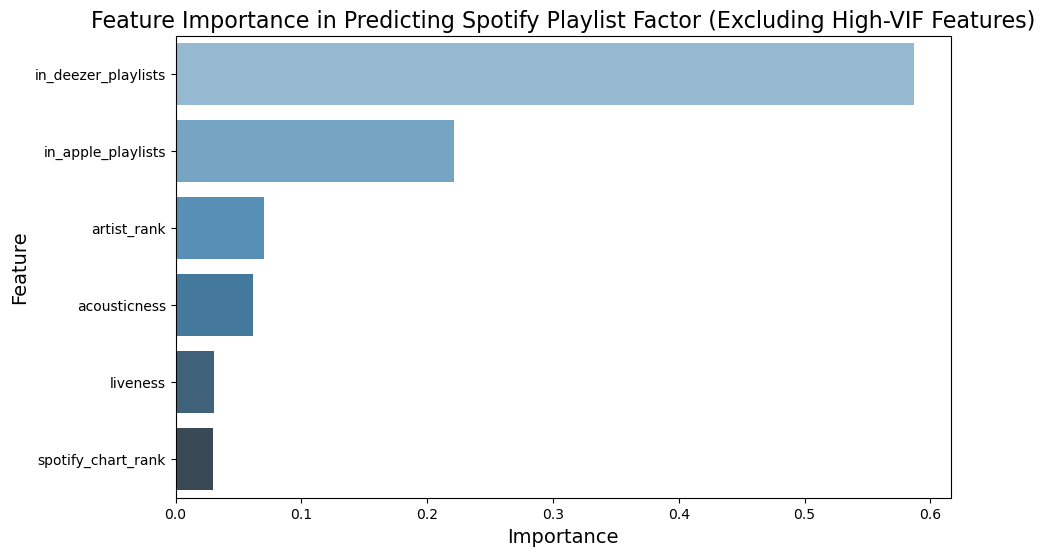

In [318]:
# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['artist_rank', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable
y = cleaned_spotify_df['in_spotify_playlists']

# Step 2: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X.drop(columns=high_vif_features)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 4: Scale the numeric columns using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 7: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"R² Score: {r2}")

# Step 8: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 9: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in Predicting Spotify Playlist Factor (Excluding High-VIF Features)', fontsize=16)
plt.show()



R² Score: 0.9021452428667581


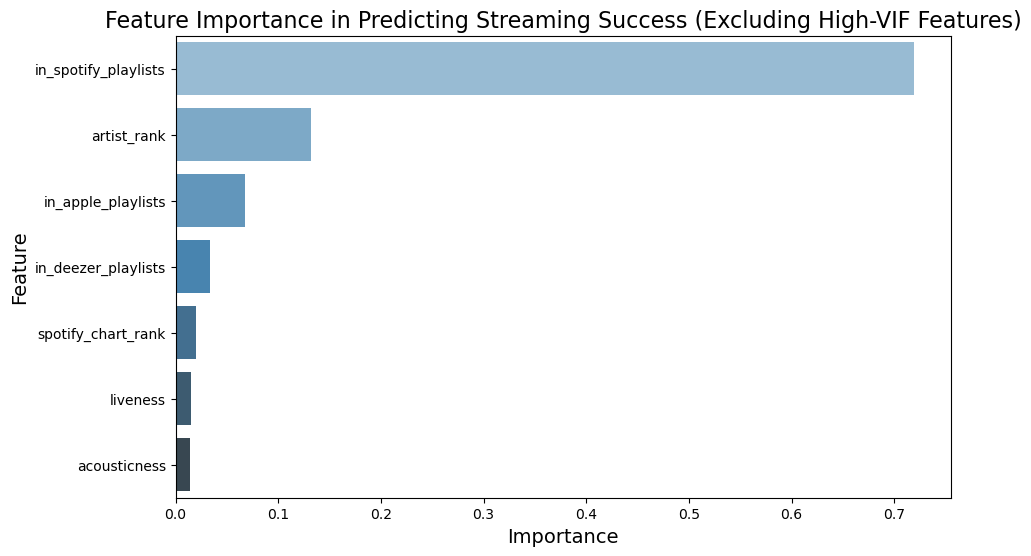

In [319]:
# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['in_spotify_playlists', 'artist_rank', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X.drop(columns=high_vif_features)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 4: Scale the numeric columns using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 7: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"R² Score: {r2}")

# Step 8: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 9: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in Predicting Streaming Success (Excluding High-VIF Features)', fontsize=16)
plt.show()



R² Score: 0.9021452428667581


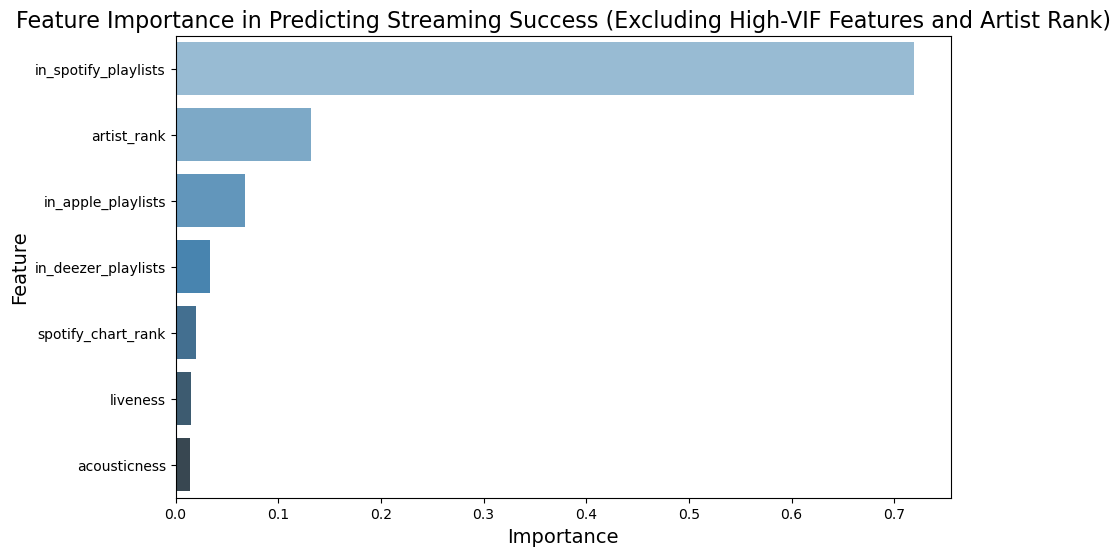

In [320]:
# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['in_spotify_playlists', 'artist_rank', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X.drop(columns=high_vif_features)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 4: Scale the numeric columns using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 7: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"R² Score: {r2}")

# Step 8: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 9: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in Predicting Streaming Success (Excluding High-VIF Features and Artist Rank)', fontsize=16)
plt.show()



R² Score: 0.9022176973186136


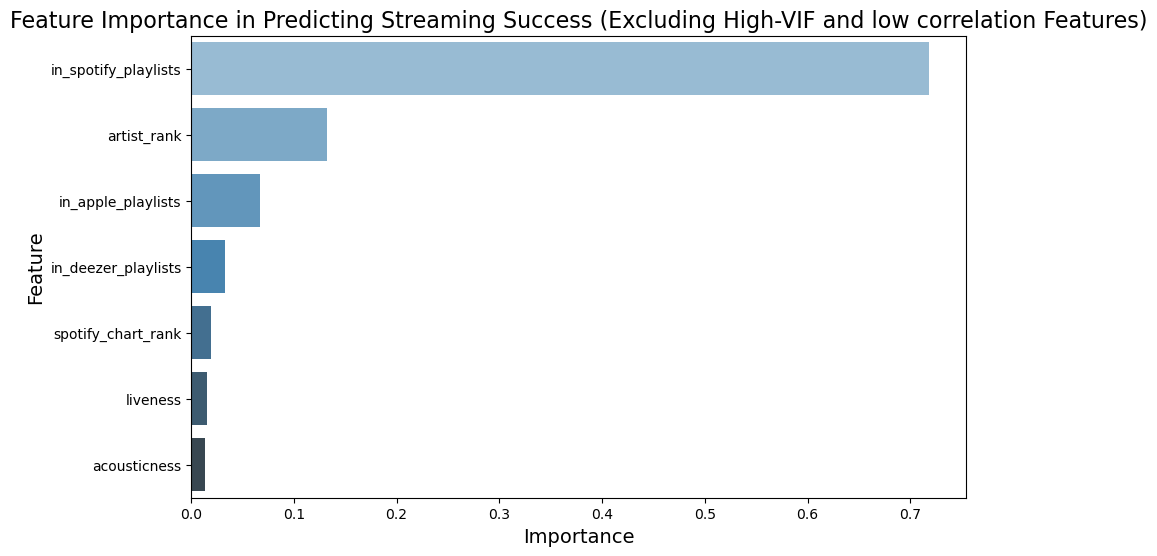

In [321]:
# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['artist_rank', 'in_spotify_playlists', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X.drop(columns=high_vif_features)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 4: Scale the numeric columns using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 7: Calculate regression metrics
r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2}")

# Step 8: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 9: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in Predicting Streaming Success (Excluding High-VIF and low correlation Features)', fontsize=16)
plt.show()



R² Score: 0.8677042384392781


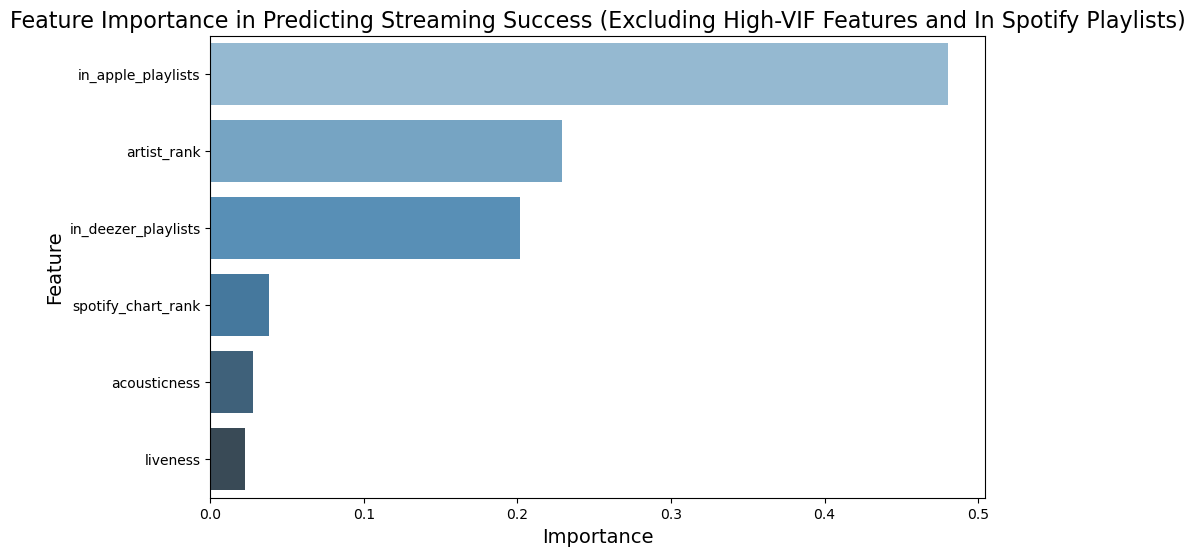

In [322]:
# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['artist_rank', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X.drop(columns=high_vif_features)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 4: Scale the numeric columns using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 7: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"R² Score: {r2}")

# Step 8: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 9: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in Predicting Streaming Success (Excluding High-VIF Features and In Spotify Playlists)', fontsize=16)
plt.show()



R² Score: 0.7129070903066024


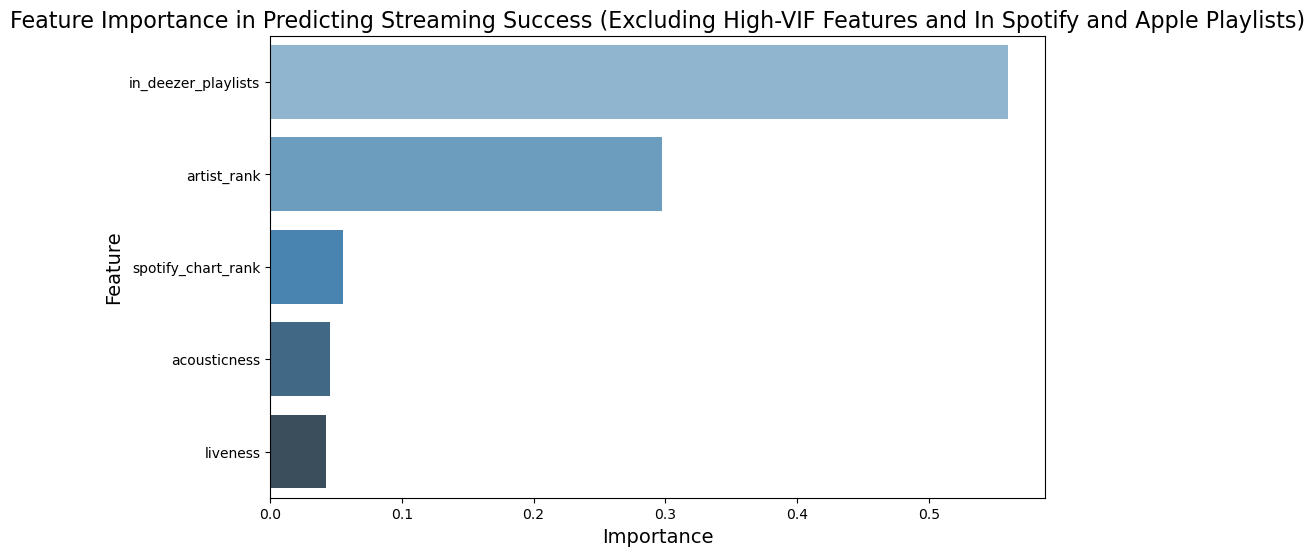

In [323]:
# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['artist_rank', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X.drop(columns=high_vif_features)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 4: Scale the numeric columns using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 7: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"R² Score: {r2}")

# Step 8: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 9: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in Predicting Streaming Success (Excluding High-VIF Features and In Spotify and Apple Playlists)', fontsize=16)
plt.show()



R² Score: 0.47786954206650245


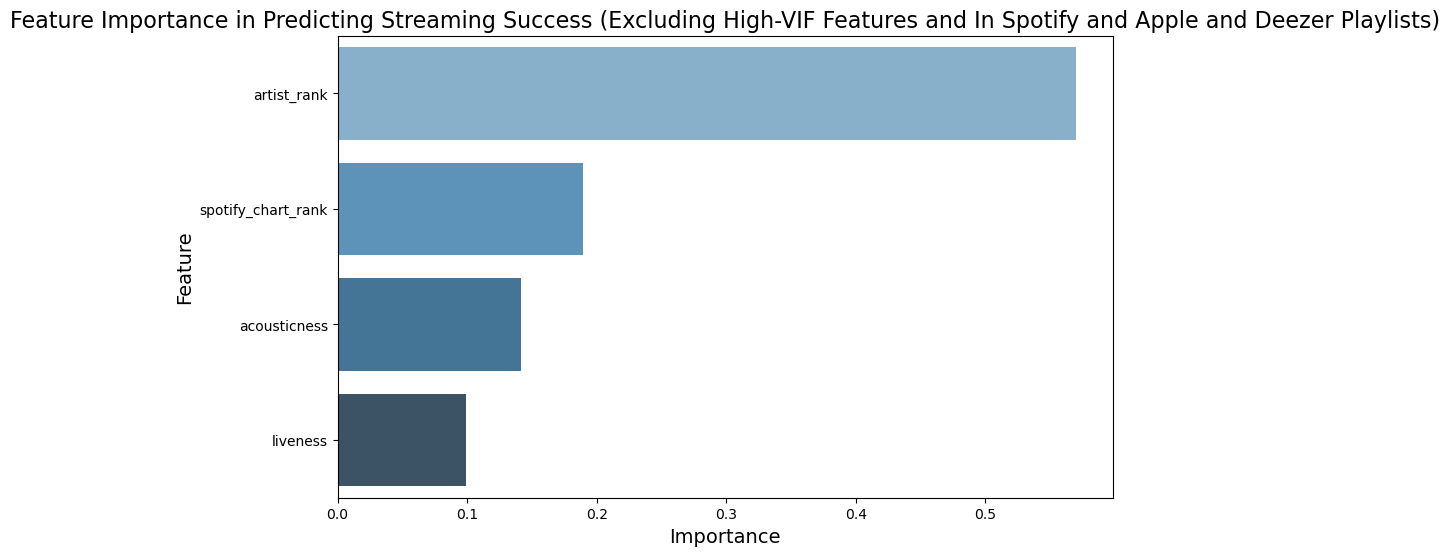

In [324]:
# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['artist_rank', 'released_year',
                        'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X.drop(columns=high_vif_features)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 4: Scale the numeric columns using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 7: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"R² Score: {r2}")

# Step 8: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 9: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in Predicting Streaming Success (Excluding High-VIF Features and In Spotify and Apple and Deezer Playlists)', fontsize=16)
plt.show()



R² Score: 0.8276891529620407


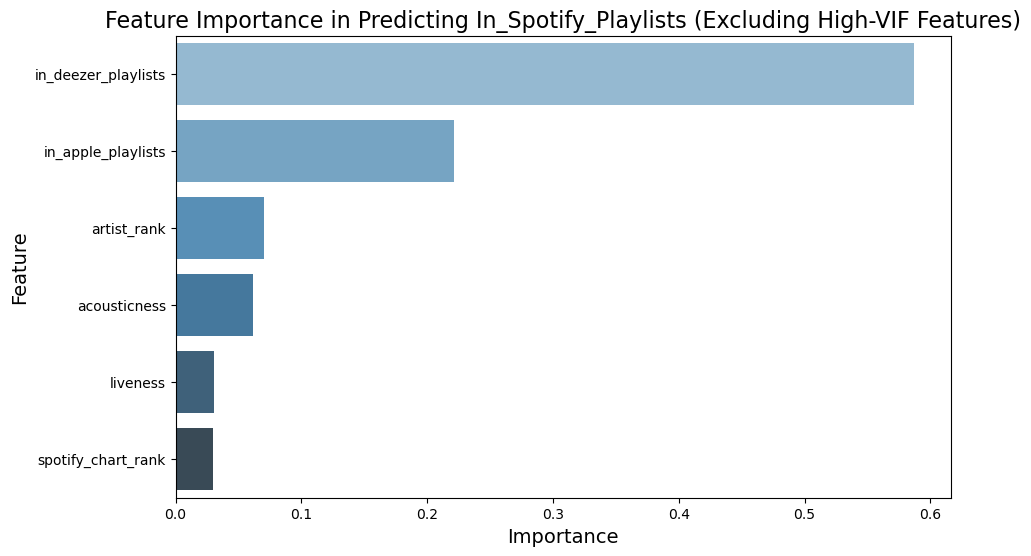

In [325]:
# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['artist_rank', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable
y = cleaned_spotify_df['in_spotify_playlists']

# Step 2: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X.drop(columns=high_vif_features)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 4: Scale the numeric columns using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 7: Calculate regression metrics
r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2}")

# Step 8: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 9: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in Predicting In_Spotify_Playlists (Excluding High-VIF Features)', fontsize=16)
plt.show()



C:\Users\npwol\AppData\Local\Temp\ipykernel_78468\497141454.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['mode'] = cleaned_spotify_df['mode_encoded']


R² Score: -0.18998777034181757


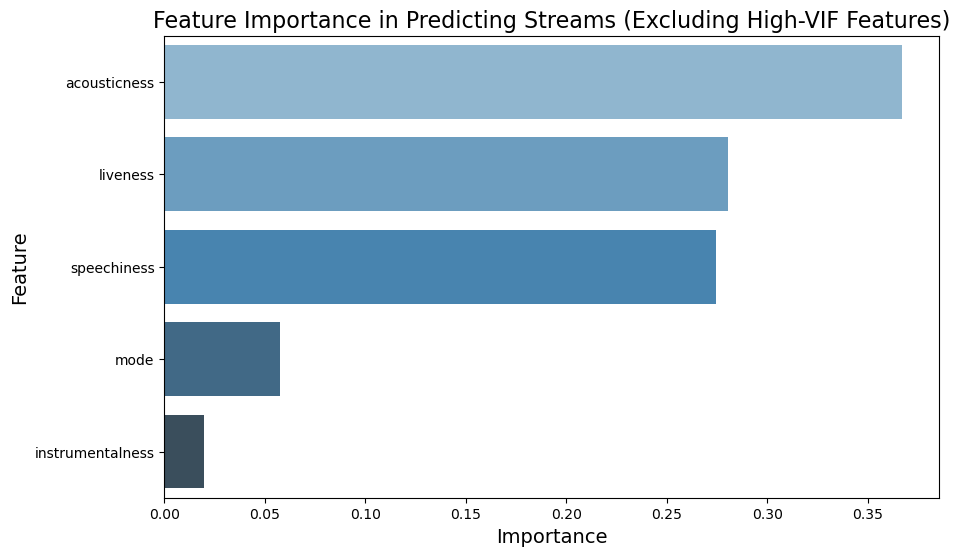

VIF Data:
            Feature        VIF
0           valence   7.716287
1               bpm  14.447685
2  instrumentalness   1.068159
3       speechiness   2.195703
4            energy  19.413819
5      danceability  18.034452
6          liveness   2.810807
7      acousticness   2.315209
8              mode   2.216561
Features excluded due to high VIF (> 5):
0         valence
1             bpm
4          energy
5    danceability
Name: Feature, dtype: object


In [326]:
# Step 1: Select the features for VIF calculation and model training, removing 'key'
X = cleaned_spotify_df[['valence', 'bpm', 'instrumentalness', 'speechiness', 
                        'energy', 'danceability', 'liveness', 'acousticness']]

# Map the 'mode' column: Assume "Major" = 1 and "Minor" = 0
cleaned_spotify_df['mode_encoded'] = cleaned_spotify_df['mode'].apply(lambda x: 1 if x == "Major" else 0)

# Add the binary encoded 'mode' column to the features
X['mode'] = cleaned_spotify_df['mode_encoded']

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Handle any missing or invalid values in X
X = X.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
X = X.dropna()  # Drop rows with NaN values

# Ensure target variable y has no missing values
y = y[X.index]  # Keep only the valid rows that correspond to X

# Step 3: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X.drop(columns=high_vif_features)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 5: Scale the numeric columns using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 7: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 8: Calculate regression metrics
r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2}")

# Step 9: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 10: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in Predicting Streams (Excluding High-VIF Features)', fontsize=16)
plt.show()

# Display VIF results
print("VIF Data:")
print(vif_data)

# Print excluded features due to high VIF
print("Features excluded due to high VIF (> 5):")
print(high_vif_features)


R² Score: 0.9025589631130375


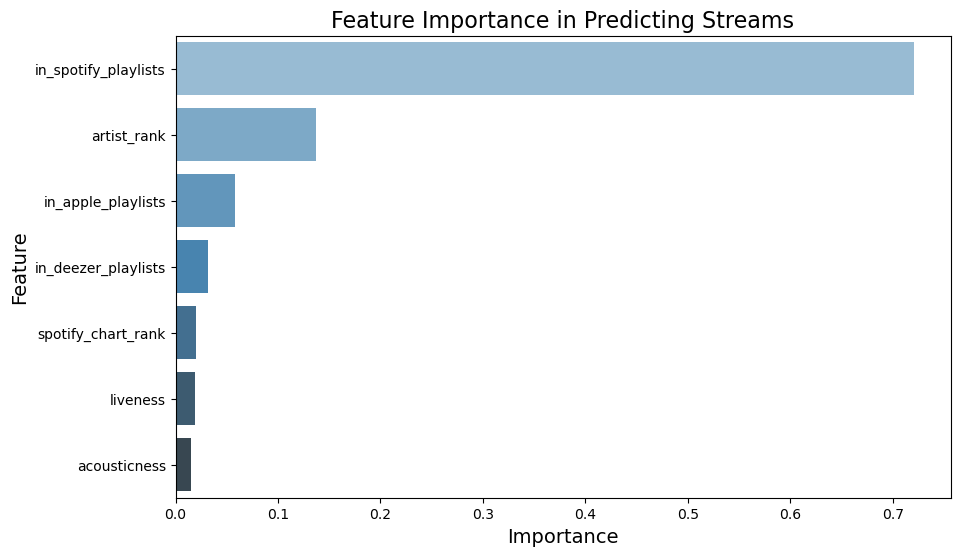

VIF Data:
                 Feature         VIF
0            artist_rank    3.409426
1   in_spotify_playlists    3.789323
2     in_apple_playlists    4.906806
3          released_year  104.925455
4    in_deezer_playlists    2.020067
5     spotify_chart_rank    1.622496
6                valence    8.598125
7                 energy   32.447973
8           danceability   34.338416
9                    bpm   22.900603
10              liveness    3.707777
11          acousticness    3.283641
Features excluded due to high VIF (> 5):
3    released_year
6          valence
7           energy
8     danceability
9              bpm
Name: Feature, dtype: object


In [327]:
from scipy.stats import mstats

# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['artist_rank', 'in_spotify_playlists', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Winsorize the columns independently
X_winsorized = X.apply(lambda col: mstats.winsorize(col, limits=[0.05, 0.05]), axis=0)

# Step 3: Handle missing or invalid values in X_winsorized
X_winsorized = X_winsorized.replace([np.inf, -np.inf], np.nan) 
X_winsorized = X_winsorized.dropna()  

# Don't use Ys without Xs
y = y[X_winsorized.index]  

# Step 4: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_winsorized.columns
vif_data["VIF"] = [variance_inflation_factor(X_winsorized.values, i) for i in range(X_winsorized.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X_winsorized.drop(columns=high_vif_features)

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 6: Scale the numeric columns using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 7: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 8: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 9: Calculate regression metrics
r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2}")

# Step 10: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 11: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in Predicting Streams', fontsize=16)
plt.show()

# Display VIF results
print("VIF Data:")
print(vif_data)

# Print excluded features due to high VIF
print("Features excluded due to high VIF (> 5):")
print(high_vif_features)


In [364]:
from scipy.stats import mstats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['artist_rank', 'in_spotify_playlists', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Winsorize the columns independently
X_winsorized = X.apply(lambda col: mstats.winsorize(col, limits=[0.05, 0.05]), axis=0)

# Step 3: Handle missing or invalid values in X_winsorized
X_winsorized = X_winsorized.replace([np.inf, -np.inf], np.nan) 
X_winsorized = X_winsorized.dropna()  

# Don't use Ys without Xs
y = y[X_winsorized.index]  

# Step 4: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_winsorized.columns
vif_data["VIF"] = [variance_inflation_factor(X_winsorized.values, i) for i in range(X_winsorized.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X_winsorized.drop(columns=high_vif_features)

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 6: Scale the numeric columns using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 7: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 8: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 9: Calculate regression metrics
r2 = r2_score(y_test, y_pred)
n = X_test.shape[0]  # Number of samples in the test set
p = X_filtered.shape[1]  # Number of features after filtering

# Calculate Adjusted R²
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"R² Score: {r2}")
print(f"Adjusted R² Score: {adjusted_r2}")

# Step 10: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 11: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in Predicting Streams', fontsize=16)
plt.show()

# Display VIF results
print("VIF Data:")
print(vif_data)

# Print excluded features due to high VIF
print("Features excluded due to high VIF (> 5):")
print(high_vif_features)


KeyError: "['artist_rank', 'liveness'] not in index"

R² Score: 0.8945496891337287


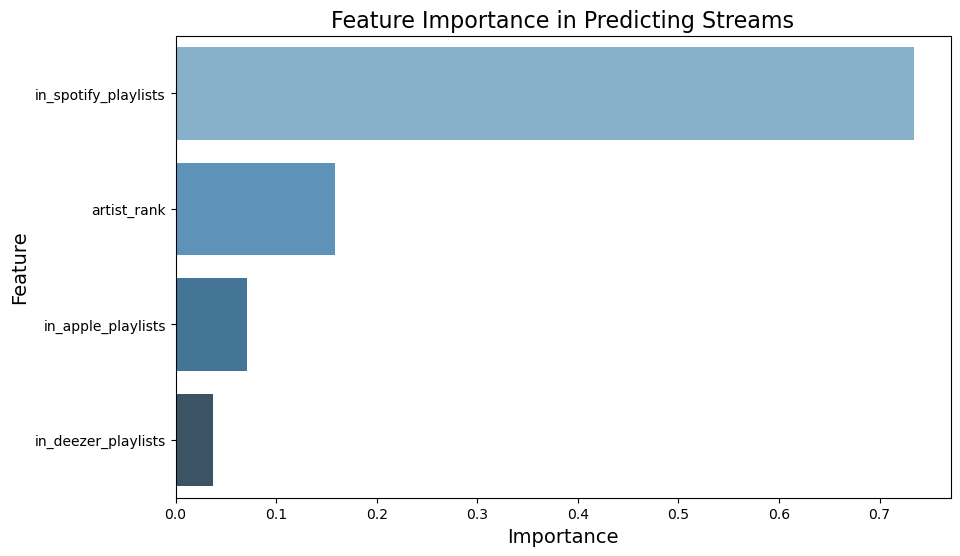

VIF Data:
                Feature        VIF
0           artist_rank   3.384775
1  in_spotify_playlists   3.786308
2    in_apple_playlists   4.822405
3         released_year  69.690184
4   in_deezer_playlists   2.011494
5               valence   8.056139
6                energy  22.128403
7          danceability  31.244403
8                   bpm  22.728222
Features excluded due to high VIF (> 5):
3    released_year
5          valence
6           energy
7     danceability
8              bpm
Name: Feature, dtype: object


In [328]:
from scipy.stats import mstats

# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['artist_rank', 'in_spotify_playlists', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'valence', 
                        'energy', 'danceability', 'bpm']]

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Winsorize the columns independently
X_winsorized = X.apply(lambda col: mstats.winsorize(col, limits=[0.05, 0.05]), axis=0)

# Step 3: Handle missing or invalid values in X_winsorized
X_winsorized = X_winsorized.replace([np.inf, -np.inf], np.nan) 
X_winsorized = X_winsorized.dropna()  

# Don't use Ys without Xs
y = y[X_winsorized.index]  

# Step 4: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_winsorized.columns
vif_data["VIF"] = [variance_inflation_factor(X_winsorized.values, i) for i in range(X_winsorized.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X_winsorized.drop(columns=high_vif_features)

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 6: Scale the numeric columns using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 7: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 8: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 9: Calculate regression metrics
r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2}")

# Step 10: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 11: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in Predicting Streams', fontsize=16)
plt.show()

# Display VIF results
print("VIF Data:")
print(vif_data)

# Print excluded features due to high VIF
print("Features excluded due to high VIF (> 5):")
print(high_vif_features)


In [329]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Select music-related features 
X = cleaned_spotify_df[['valence', 'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]
y = cleaned_spotify_df['artists_name']  # The target 

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Step 3: Scale the numeric columns using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=7)
rf_classifier.fit(X_train_scaled, y_train)

# Step 5: Make predictions on the test 
y_pred = rf_classifier.predict(X_test_scaled)

# Step 6: Evaluate classification performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') 
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print classification metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.036585365853658534
Precision: 0.02932636469221835
Recall: 0.036585365853658534
F1 Score: 0.027073170731707313


c:\Users\npwol\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\npwol\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [330]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Select the music-related features and 'artists_name' as the target
X = cleaned_spotify_df[['streams']]
y = cleaned_spotify_df['artists_name']  # The target is to classify based on 'artists_name'

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Step 3: Scale the numeric columns using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=7)
rf_classifier.fit(X_train_scaled, y_train)

# Step 5: Make predictions on the test set
y_pred = rf_classifier.predict(X_test_scaled)

# Step 6: Evaluate classification performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print classification metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.012195121951219513
Precision: 0.026422764227642274
Recall: 0.012195121951219513
F1 Score: 0.016666666666666666


c:\Users\npwol\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\npwol\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [331]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Select music-related features 
X = cleaned_spotify_df[['liveness', 'acousticness', 'in_spotify_playlists', 
                        'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'artist_rank']]

y = cleaned_spotify_df['artists_name']  # The target 

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Step 3: Scale numeric columns using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=7)
rf_classifier.fit(X_train_scaled, y_train)

# Step 5: Make predictions on test 
y_pred = rf_classifier.predict(X_test_scaled)

# Step 6: 
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print classification metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.20121951219512196
Precision: 0.19817073170731708
Recall: 0.20121951219512196
F1 Score: 0.19535423925667827


c:\Users\npwol\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\npwol\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


R² Score: 0.8945496891337287


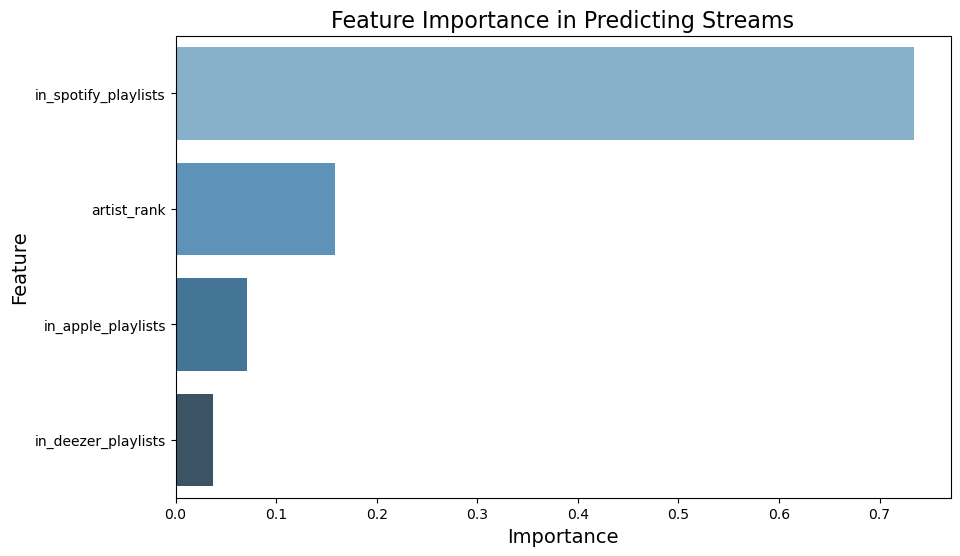

VIF Data:
                Feature        VIF
0           artist_rank   3.384775
1  in_spotify_playlists   3.786308
2    in_apple_playlists   4.822405
3         released_year  69.690184
4   in_deezer_playlists   2.011494
5               valence   8.056139
6                energy  22.128403
7          danceability  31.244403
8                   bpm  22.728222


In [332]:
# Step 1: Select the features for VIF calculation and model training
X = cleaned_spotify_df[['artist_rank', 'in_spotify_playlists', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'valence', 
                        'energy', 'danceability', 'bpm']]

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Winsorize the columns independently
X_winsorized = X.apply(lambda col: mstats.winsorize(col, limits=[0.05, 0.05]), axis=0)

# Step 3: Handle missing or invalid values in X_winsorized
X_winsorized = X_winsorized.replace([np.inf, -np.inf], np.nan) 
X_winsorized = X_winsorized.dropna()  

# Don't use Ys without Xs
y = y[X_winsorized.index]  

# Step 4: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_winsorized.columns
vif_data["VIF"] = [variance_inflation_factor(X_winsorized.values, i) for i in range(X_winsorized.shape[1])]

# Filter out features with VIF > 5
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
X_filtered = X_winsorized.drop(columns=high_vif_features)

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

# Step 6: Scale the numeric columns using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 7: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 8: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 9: Calculate regression metrics
r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2}")

# Step 10: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_filtered.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 11: Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in Predicting Streams', fontsize=16)
plt.show()

# Display VIF results
print("VIF Data:")
print(vif_data)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Select music-related features 
X = cleaned_spotify_df[['liveness', 'acousticness', 'in_spotify_playlists', 
                        'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'artist_rank']]

y = cleaned_spotify_df['artists_name']  # The target 

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Step 3: Scale numeric columns using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=7)
rf_classifier.fit(X_train_scaled, y_train)

# Step 5: Make predictions on test 
y_pred = rf_classifier.predict(X_test_scaled)

# Step 6: 
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print classification metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.20121951219512196
Precision: 0.19817073170731708
Recall: 0.20121951219512196
F1 Score: 0.19535423925667827


c:\Users\npwol\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\npwol\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [346]:
old_spotify_df.rename(columns={
    'acousticness_%': 'acousticness',
    'instrumentalness_%': 'instrumentalness',
    'liveness_%': 'liveness',
    'speechiness_%': 'speechiness',
    'artist(s)_name': 'artists_name'
}, inplace=True)

# Check if the renaming worked for all columns
print(old_spotify_df.columns)


Index(['track_name', 'artists_name', 'contributing_artist_count',
       'released_year', 'released_month', 'in_spotify_playlists',
       'spotify_chart_rank', 'streams', 'in_apple_playlists',
       'apple_chart_rank', 'in_deezer_playlists', 'deezer_chart_rank',
       'shazam_chart_rank', 'bpm', 'key', 'mode', 'danceability_%',
       'valence_%', 'energy_%', 'acousticness', 'instrumentalness', 'liveness',
       'speechiness'],
      dtype='object')


Index(['track_name', 'artists_name', 'contributing_artist_count',
       'released_year', 'released_month', 'in_spotify_playlists',
       'spotify_chart_rank', 'streams', 'in_apple_playlists',
       'apple_chart_rank', 'in_deezer_playlists', 'deezer_chart_rank',
       'shazam_chart_rank', 'bpm', 'key', 'mode', 'danceability', 'valence',
       'energy', 'acousticness', 'instrumentalness', 'liveness',
       'speechiness'],
      dtype='object')

Running analysis for cluster 0
R² Score for cluster 0: 0.7211190442906128


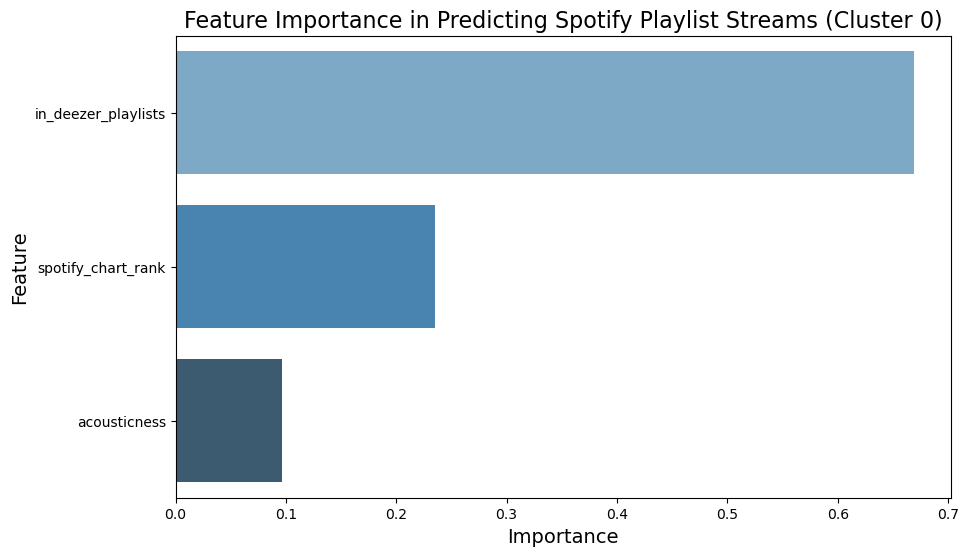


Running analysis for cluster 1
R² Score for cluster 1: 0.7751327350483359


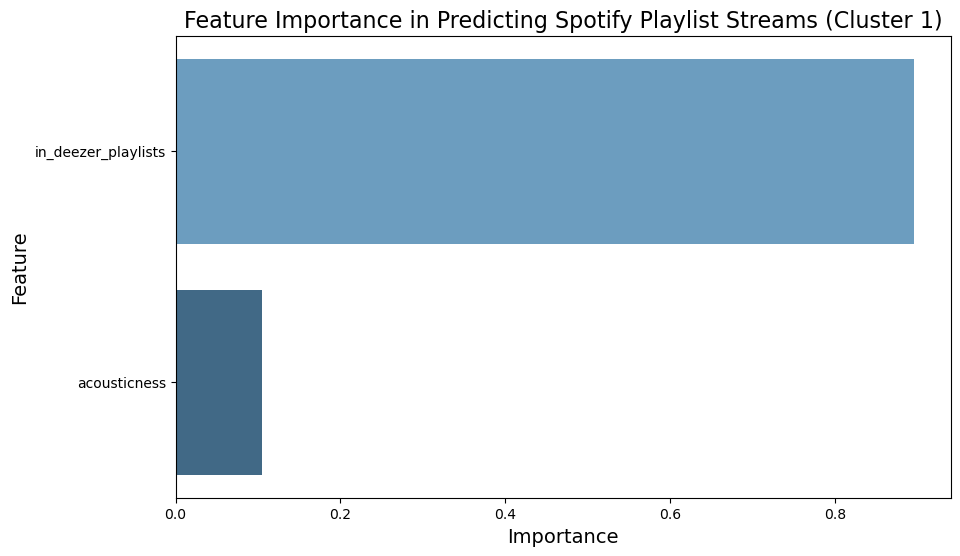


Running analysis for cluster 2
R² Score for cluster 2: 0.6860986342045834


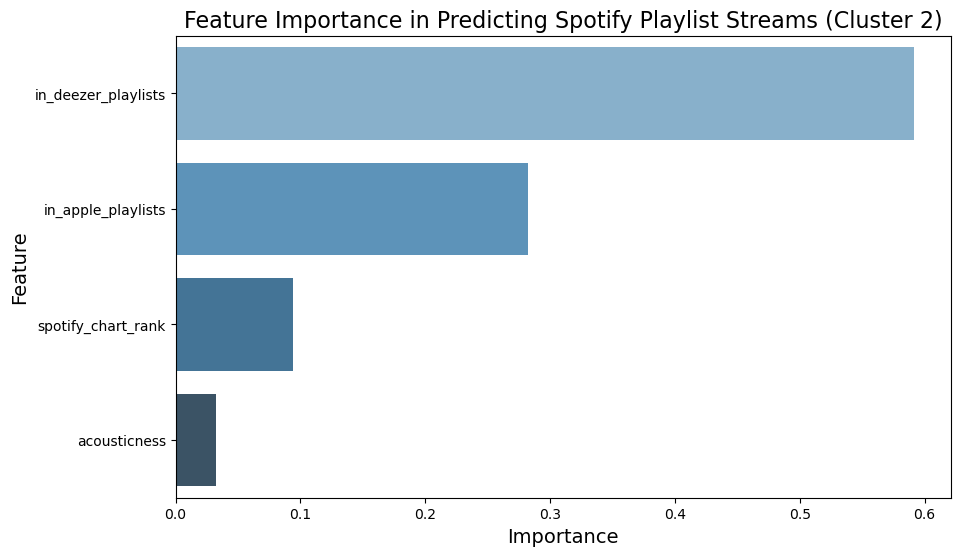

In [352]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt

# Load both datasets
clustered_spotify_df = pd.read_csv('Resources/KmeansCluster_spotify.csv')
old_spotify_df = pd.read_csv('Resources/cleaned_spotify_2023.csv')

# Rename columns to remove '%' and change 'artist(s)_name' to 'artists_name'
old_spotify_df.rename(columns={
    'acousticness_%': 'acousticness',
    'instrumentalness_%': 'instrumentalness',
    'liveness_%': 'liveness',
    'speechiness_%': 'speechiness',
    'danceability_%': 'danceability',
    'valence_%': 'valence',
    'energy_%': 'energy',
    'artist(s)_name': 'artists_name'
}, inplace=True)

# Check if the renaming worked for all columns
print(old_spotify_df.columns)

# Now merge the datasets on 'artists_name'
cleaned_spotify_df = pd.merge(clustered_spotify_df, 
                              old_spotify_df[['artists_name', 'valence', 'energy', 'danceability', 'acousticness']], 
                              on='artists_name', how='left')

# Optionally handle missing values after merging
cleaned_spotify_df.fillna(0, inplace=True)  # Fill NaN with 0, or you can dropna() if needed

# Iterate over each cluster (0, 1, 2)
for cluster in [0, 1, 2]:
    print(f"\nRunning analysis for cluster {cluster}")
    
    # Filter data for the current cluster
    cluster_data = cleaned_spotify_df[cleaned_spotify_df['cluster'] == cluster]

    # Step 1: Select the features for VIF calculation and model training
    X = cluster_data[['in_apple_playlists', 'released_year', 
                      'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                      'energy', 'danceability', 'bpm', 'acousticness']]

    # Step 2: Set the target variable
    y = cluster_data['in_spotify_playlists']

    # Step 3: Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Filter out features with VIF > 5
    high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
    X_filtered = X.drop(columns=high_vif_features)

    # Step 4: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

    # Step 5: Scale the numeric columns
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Step 6: Train the RandomForestRegressor
    rf = RandomForestRegressor(n_estimators=1000, random_state=7)
    rf.fit(X_train_scaled, y_train)

    # Step 7: Make predictions on the test set
    y_pred = rf.predict(X_test_scaled)

    # Step 8: Calculate regression metrics
    r2 = r2_score(y_test, y_pred)

    # Print the R² for the prediction
    print(f"R² Score for cluster {cluster}: {r2}")

    # Step 9: Evaluate feature importance
    importances = rf.feature_importances_
    feature_names = X_filtered.columns  
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

    # Sort by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Step 10: Plot the feature importances using Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.title(f'Feature Importance in Predicting Spotify Playlist Streams (Cluster {cluster})', fontsize=16)
    plt.show()


In [357]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt

# Load both datasets
clustered_spotify_df = pd.read_csv('Resources/KmeansCluster_spotify.csv')
old_spotify_df = pd.read_csv('Resources/cleaned_spotify_2023.csv')

# Rename columns to remove '%' and change 'artist(s)_name' to 'artists_name'
old_spotify_df.rename(columns={
    'acousticness_%': 'acousticness',
    'instrumentalness_%': 'instrumentalness',
    'liveness_%': 'liveness',
    'speechiness_%': 'speechiness',
    'danceability_%': 'danceability',
    'valence_%': 'valence',
    'energy_%': 'energy',
    'artist(s)_name': 'artists_name'
}, inplace=True)

# Check if the renaming worked for all columns
print(old_spotify_df.columns)

# Now merge the datasets on 'artists_name'
cleaned_spotify_df = pd.merge(clustered_spotify_df, 
                              old_spotify_df[['artists_name', 'valence', 'energy', 'danceability', 'acousticness', 'streams']], 
                              on='artists_name', how='left')

# Optionally handle missing values after merging
cleaned_spotify_df.fillna(0, inplace=True)  # Fill NaN with 0, or you can dropna() if needed

# Iterate over each cluster (0, 1, 2)
for cluster in [0, 1, 2]:
    print(f"\nRunning analysis for cluster {cluster}")
    
    # Filter data for the current cluster
    cluster_data = cleaned_spotify_df[cleaned_spotify_df['cluster'] == cluster]

    # Print the top 5 artists in each cluster based on streams
    top_5_artists = cluster_data[['artists_name', 'streams']].sort_values(by='streams', ascending=False).head(5)
    print(f"Top 5 artists in cluster {cluster}:")
    print(top_5_artists)

    # Step 1: Select the features for VIF calculation and model training
    X = cluster_data[['in_apple_playlists', 'released_year', 
                      'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                      'energy', 'danceability', 'bpm', 'acousticness']]

    # Step 2: Set the target variable
    y = cluster_data['in_spotify_playlists']

    # Step 3: Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Filter out features with VIF > 5
    high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
    X_filtered = X.drop(columns=high_vif_features)

    # Step 4: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=7)

    # Step 5: Scale the numeric columns
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Step 6: Train the RandomForestRegressor
    rf = RandomForestRegressor(n_estimators=1000, random_state=7)
    rf.fit(X_train_scaled, y_train)

    # Step 7: Make predictions on the test set
    y_pred = rf.predict(X_test_scaled)

    # Step 8: Calculate regression metrics
    r2 = r2_score(y_test, y_pred)

    # Print the R² for the prediction
    print(f"R² Score for cluster {cluster}: {r2}")

    # Step 9: Evaluate feature importance
    importances = rf.feature_importances_
    feature_names = X_filtered.columns  
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

    # Sort by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Step 10: Plot the feature importances using Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.title(f'Feature Importance in Predicting Spotify Playlist Streams (Cluster {cluster})', fontsize=16)
    plt.show()


Index(['track_name', 'artists_name', 'contributing_artist_count',
       'released_year', 'released_month', 'in_spotify_playlists',
       'spotify_chart_rank', 'streams', 'in_apple_playlists',
       'apple_chart_rank', 'in_deezer_playlists', 'deezer_chart_rank',
       'shazam_chart_rank', 'bpm', 'key', 'mode', 'danceability', 'valence',
       'energy', 'acousticness', 'instrumentalness', 'liveness',
       'speechiness'],
      dtype='object')

Running analysis for cluster 0


KeyError: "['streams'] not in index"